## Set up Google Drive

In [2]:
SET_UP_GOOGLE_DRIVE = False

PROJECT_PATH = "."
if SET_UP_GOOGLE_DRIVE:
    from google.colab import drive

    drive.mount('/content/gdrive')

    PROJECT_PATH = "/content/gdrive/Shareddrives/PFE - ING3 Mlamali/DrumClassifier - Project"
    import sys

    sys.path.append(PROJECT_PATH)

PROJECT_PATH

'.'

In [3]:
from params import SOUNDS_DATASET_PATH, SAMPLE_RATE, CLASS_COLORS

if SET_UP_GOOGLE_DRIVE:
    SOUNDS_DATASET_PATH = "/content/gdrive/Shareddrives/PFE - ING3 Mlamali/DrumClassifier - Sounds Dataset"
SOUNDS_DATASET_PATH

'G:\\Shared drives\\PFE - ING3 Mlamali\\DrumClassifier - Sounds Dataset'

## Imports

In [4]:
try:
    import lazypredict
    import dataframe_image as dfi
except:
    !pip install lazypredict
    !pip install dataframe_image
    import lazypredict
    import dataframe_image as dfi

In [5]:
import pandas as pd
import numpy as np
import re

import seaborn as sns  # library for visualization

sns.set_style("darkgrid")
import matplotlib.pyplot as plt  # library for visualization
%matplotlib inline

from tqdm import tqdm
from tools import *

tqdm.pandas()
import os
from glob import glob
import random
from datetime import datetime

from typing import List, Tuple, Dict, Union

from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle
import warnings
import re

In [6]:

#importing essential libraries
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, recall_score, \
    precision_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, auc, f1_score
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import cycle




## Dataset

### Load

In [7]:
now_day_str = "20230511"
MIN_SAMPLES_PER_CLASS = 600
df_drums = pd.read_csv(
    os.path.join(SOUNDS_DATASET_PATH.replace("\\", "/"),
                 f'dataset_features_cleaned_augmented_{MIN_SAMPLES_PER_CLASS}_{now_day_str}.csv'),
    dtype={"orig_file_path": str})
df_drums.set_index("file_path", inplace=True)
df_drums

,file_name,file_extension,class,split,duration,rms_log_sum,rms_log_mean,rms_log_max,rms_log_std,rms_log_diff_abs_mean,...,spec_flatness_mean,spec_flatness_std,spec_rolloff_85_mean,spec_rolloff_85_std,spec_rolloff_15_mean,spec_rolloff_15_std,spec_contrast_mean,spec_contrast_std,orig_file_path,is_augmented
file_path,,,,,,,,,,,,,,,,,,,,,
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\Shaker (86).wav,Shaker (86),.wav,Shaker,train,0.271746,-67.922790,-2.830116,-0.979739,1.160011,0.201043,...,0.238786,0.060366,18053.796387,1393.806008,5028.002930,3072.527272,13.643418,3.420110,NaN,0
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\shaker (2) (2).wav,shaker (2) (2),.wav,Shaker,train,2.821746,-1251.780600,-5.130249,-0.586314,1.711829,0.043277,...,0.810217,0.365054,2866.563541,5542.881827,536.388560,1097.454240,9.787767,3.063742,NaN,0
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\Shaker (85).wav,Shaker (85),.wav,Shaker,train,0.089456,-13.053484,-1.631685,-1.033871,0.477110,0.322956,...,0.150005,0.045579,16413.684082,1311.129402,5151.818848,1894.669516,15.115996,7.899844,NaN,0
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\Shaker 2 (6).wav,Shaker 2 (6),.wav,Shaker,train,0.198980,-31.089748,-1.727208,-0.707821,0.794459,0.233574,...,0.147244,0.023006,14054.003906,650.565706,4562.646484,283.850935,13.879188,5.296295,NaN,0
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\PBJ Perc - Shaker.wav,PBJ Perc - Shaker,.wav,Shaker,train,0.461542,-94.645390,-2.366135,-1.157960,0.568292,0.106450,...,0.020956,0.011112,12849.400635,672.115181,5931.320801,1290.223010,19.733333,9.117705,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Snap\Snap3@augmented__noise_1__ts_1__ps_1__pi_1__rg_1.wav,NaN,NaN,Snap,train,0.140000,-37.095688,-2.853514,-0.744207,1.971607,0.439677,...,0.182236,0.349283,9000.878906,2799.010593,1679.589844,541.994813,15.632654,11.775988,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,1
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Snap\Snap (10)@augmented__noise_1__ts_1__ps_1__pi_1__rg_1.wav,NaN,NaN,Snap,train,1.957982,-495.944153,-2.934581,-1.076636,1.165054,0.040011,...,0.132871,0.301982,12548.251144,4340.964154,1894.667044,805.957408,19.830304,19.617688,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,1
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Snap\SnapStar (5)@augmented__noise_1__ps_1__pi_1__ts_1.wav,NaN,NaN,Snap,train,2.303787,-460.600708,-2.314576,-0.724024,0.246351,0.025764,...,0.083700,0.031955,15648.795491,1495.520024,2723.246849,278.389762,19.344172,20.491816,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,1


### Columns names

In [8]:
print(f'Nombre de colonnes: {len(df_drums.columns)}')
df_drums.columns

Nombre de colonnes: 104


Index(['file_name', 'file_extension', 'class', 'split', 'duration',
       'rms_log_sum', 'rms_log_mean', 'rms_log_max', 'rms_log_std',
       'rms_log_diff_abs_mean',
       ...
       'spec_flatness_mean', 'spec_flatness_std', 'spec_rolloff_85_mean',
       'spec_rolloff_85_std', 'spec_rolloff_15_mean', 'spec_rolloff_15_std',
       'spec_contrast_mean', 'spec_contrast_std', 'orig_file_path',
       'is_augmented'],
      dtype='object', length=104)

In [9]:
columns_by_prefix = get_columns_by_prefix_(df_drums.columns)
columns_by_prefix

{'zcr': ['zcr_sum', 'zcr_mean', 'zcr_std', 'zcr_loudest_frame'],
 'file': ['file_name', 'file_extension'],
 'orig': ['orig_file_path'],
 'split': ['split'],
 'attack': ['attack_time'],
 'spec': ['spec_cent_mean',
  'spec_cent_std',
  'spec_bw_mean',
  'spec_bw_std',
  'spec_flatness_mean',
  'spec_flatness_std',
  'spec_rolloff_85_mean',
  'spec_rolloff_85_std',
  'spec_rolloff_15_mean',
  'spec_rolloff_15_std',
  'spec_contrast_mean',
  'spec_contrast_std'],
 'mfcc': ['mfcc_mean_1',
  'mfcc_mean_2',
  'mfcc_mean_3',
  'mfcc_mean_4',
  'mfcc_mean_5',
  'mfcc_mean_6',
  'mfcc_mean_7',
  'mfcc_mean_8',
  'mfcc_mean_9',
  'mfcc_mean_10',
  'mfcc_mean_11',
  'mfcc_mean_12',
  'mfcc_std_1',
  'mfcc_std_2',
  'mfcc_std_3',
  'mfcc_std_4',
  'mfcc_std_5',
  'mfcc_std_6',
  'mfcc_std_7',
  'mfcc_std_8',
  'mfcc_std_9',
  'mfcc_std_10',
  'mfcc_std_11',
  'mfcc_std_12',
  'mfcc_max_1',
  'mfcc_max_2',
  'mfcc_max_3',
  'mfcc_max_4',
  'mfcc_max_5',
  'mfcc_max_6',
  'mfcc_max_7',
  'mfcc_max_8'

### Checking data types and correct



In [10]:
df_drums.dtypes

file_name               object
file_extension          object
class                   object
split                   object
duration               float64
                        ...   
spec_rolloff_15_std    float64
spec_contrast_mean     float64
spec_contrast_std      float64
orig_file_path          object
is_augmented             int64
Length: 104, dtype: object

In [11]:
df_drums["is_augmented"] = df_drums["is_augmented"].astype(bool)

### Features columns

In [12]:
# get columns names with float type use .info()
features_columns = [k for k, v in df_drums.dtypes.to_dict().items() if v == 'float64' or v == 'int64']
if 'is_augmented' in features_columns:
    features_columns.remove('is_augmented')

print(f"Nombre de features: {len(features_columns)}")
get_columns_by_prefix_(features_columns)

Nombre de features: 98


{'zcr': ['zcr_sum', 'zcr_mean', 'zcr_std', 'zcr_loudest_frame'],
 'attack': ['attack_time'],
 'spec': ['spec_cent_mean',
  'spec_cent_std',
  'spec_bw_mean',
  'spec_bw_std',
  'spec_flatness_mean',
  'spec_flatness_std',
  'spec_rolloff_85_mean',
  'spec_rolloff_85_std',
  'spec_rolloff_15_mean',
  'spec_rolloff_15_std',
  'spec_contrast_mean',
  'spec_contrast_std'],
 'mfcc': ['mfcc_mean_1',
  'mfcc_mean_2',
  'mfcc_mean_3',
  'mfcc_mean_4',
  'mfcc_mean_5',
  'mfcc_mean_6',
  'mfcc_mean_7',
  'mfcc_mean_8',
  'mfcc_mean_9',
  'mfcc_mean_10',
  'mfcc_mean_11',
  'mfcc_mean_12',
  'mfcc_std_1',
  'mfcc_std_2',
  'mfcc_std_3',
  'mfcc_std_4',
  'mfcc_std_5',
  'mfcc_std_6',
  'mfcc_std_7',
  'mfcc_std_8',
  'mfcc_std_9',
  'mfcc_std_10',
  'mfcc_std_11',
  'mfcc_std_12',
  'mfcc_max_1',
  'mfcc_max_2',
  'mfcc_max_3',
  'mfcc_max_4',
  'mfcc_max_5',
  'mfcc_max_6',
  'mfcc_max_7',
  'mfcc_max_8',
  'mfcc_max_9',
  'mfcc_max_10',
  'mfcc_max_11',
  'mfcc_max_12',
  'mfcc_min_1',
  'mfcc

In [13]:
not_features_columns = df_drums.columns[~df_drums.columns.isin(features_columns)].tolist()
not_features_columns

['file_name',
 'file_extension',
 'class',
 'split',
 'orig_file_path',
 'is_augmented']

In [14]:
df_drums[features_columns].head()

,duration,rms_log_sum,rms_log_mean,rms_log_max,rms_log_std,rms_log_diff_abs_mean,rms_log_crest_factor,zcr_sum,zcr_mean,zcr_std,...,spec_bw_mean,spec_bw_std,spec_flatness_mean,spec_flatness_std,spec_rolloff_85_mean,spec_rolloff_85_std,spec_rolloff_15_mean,spec_rolloff_15_std,spec_contrast_mean,spec_contrast_std
file_path,,,,,,,,,,,,,,,,,,,,,
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\Shaker (86).wav,0.271746,-67.922790,-2.830116,-0.979739,1.160011,0.201043,1.850377,10.727539,0.446981,0.121935,...,5551.947561,1167.818323,0.238786,0.060366,18053.796387,1393.806008,5028.002930,3072.527272,13.643418,3.420110
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\shaker (2) (2).wav,2.821746,-1251.780600,-5.130249,-0.586314,1.711829,0.043277,4.543935,9.925781,0.040679,0.082806,...,1086.457660,2078.200191,0.810217,0.365054,2866.563541,5542.881827,536.388560,1097.454240,9.787767,3.063742
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\Shaker (85).wav,0.089456,-13.053484,-1.631685,-1.033871,0.477110,0.322956,0.597815,3.177734,0.397217,0.178777,...,4920.181711,451.140152,0.150005,0.045579,16413.684082,1311.129402,5151.818848,1894.669516,15.115996,7.899844
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\Shaker 2 (6).wav,0.198980,-31.089748,-1.727208,-0.707821,0.794459,0.233574,1.019388,6.751953,0.375109,0.074987,...,4302.722296,132.400040,0.147244,0.023006,14054.003906,650.565706,4562.646484,283.850935,13.879188,5.296295
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\PBJ Perc - Shaker.wav,0.461542,-94.645390,-2.366135,-1.157960,0.568292,0.106450,1.208174,14.026367,0.350659,0.078246,...,3757.180048,245.430780,0.020956,0.011112,12849.400635,672.115181,5931.320801,1290.223010,19.733333,9.117705


### Missing Values
check for missing values.

In [15]:
df_drums.isnull().any()

file_name               True
file_extension          True
class                  False
split                  False
duration               False
                       ...  
spec_rolloff_15_std    False
spec_contrast_mean     False
spec_contrast_std      False
orig_file_path          True
is_augmented           False
Length: 104, dtype: bool

In [16]:
df_drums.columns[df_drums.isna().any()]

Index(['file_name', 'file_extension', 'mfcc_skew_1', 'mfcc_skew_2',
       'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5', 'mfcc_skew_6',
       'mfcc_skew_7', 'mfcc_skew_8', 'mfcc_skew_9', 'mfcc_skew_10',
       'mfcc_skew_11', 'mfcc_skew_12', 'mfcc_kurtosis_1', 'mfcc_kurtosis_2',
       'mfcc_kurtosis_3', 'mfcc_kurtosis_4', 'mfcc_kurtosis_5',
       'mfcc_kurtosis_6', 'mfcc_kurtosis_7', 'mfcc_kurtosis_8',
       'mfcc_kurtosis_9', 'mfcc_kurtosis_10', 'mfcc_kurtosis_11',
       'mfcc_kurtosis_12', 'orig_file_path'],
      dtype='object')

<Axes: >

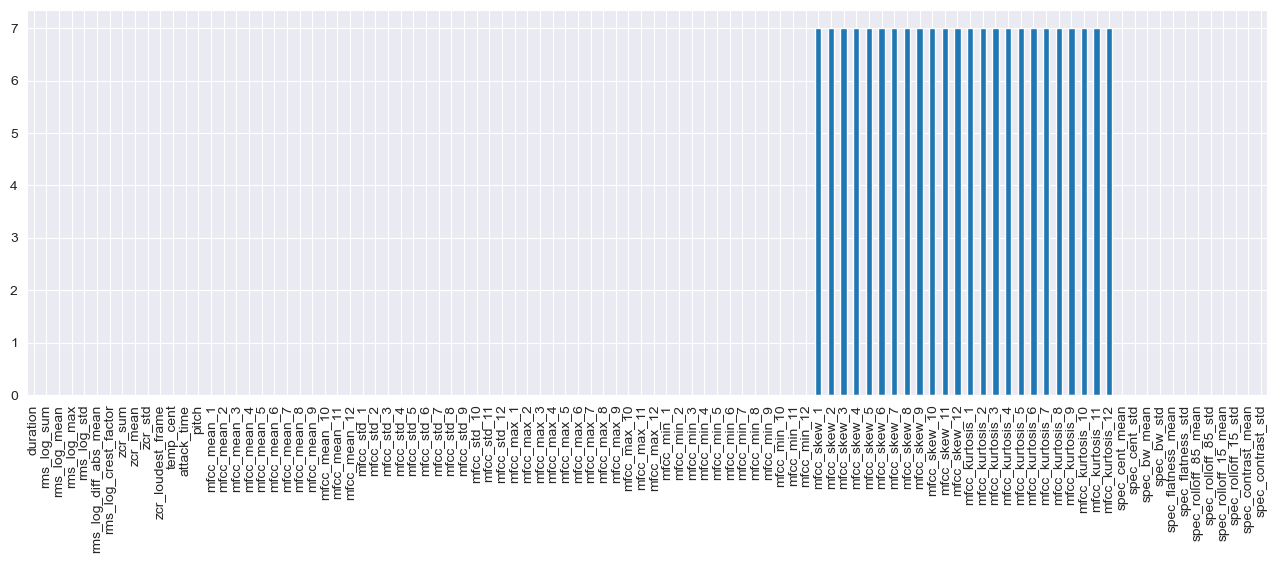

In [17]:
# count missing values per column (in features columns)
df_drums[features_columns].isna().sum().plot(kind='bar', figsize=(16, 5))

In [18]:
# display rows with missing values in features columns
df_drums[df_drums[features_columns].isna().any(axis=1)]

,file_name,file_extension,class,split,duration,rms_log_sum,rms_log_mean,rms_log_max,rms_log_std,rms_log_diff_abs_mean,...,spec_flatness_mean,spec_flatness_std,spec_rolloff_85_mean,spec_rolloff_85_std,spec_rolloff_15_mean,spec_rolloff_15_std,spec_contrast_mean,spec_contrast_std,orig_file_path,is_augmented
file_path,,,,,,,,,,,,,,,,,,,,,
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Hat Open (Cymbal)\[OPEN-HATS] Nxsty UK Drill Kit V2 (1).wav,[OPEN-HATS] Nxsty UK Drill Kit V2 (1),.wav,Hat Open (Cymbal),train,0.04644,-30.0,-6.0,-6.0,0.0,0.0,...,1.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Ride (Cymbal)\VIP PRODUCERS - FPC_Ride_GLite_004.wav,VIP PRODUCERS - FPC_Ride_GLite_004,.wav,Ride (Cymbal),train,0.04644,-30.0,-6.0,-6.0,0.0,0.0,...,1.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Ride (Cymbal)\VIP PRODUCERS - FPC_Ride_FDrk_004.wav,VIP PRODUCERS - FPC_Ride_FDrk_004,.wav,Ride (Cymbal),train,0.04644,-30.0,-6.0,-6.0,0.0,0.0,...,1.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Conga\Afro 808 Conga.wav,Afro 808 Conga,.wav,Conga,train,0.04644,-30.0,-6.0,-6.0,0.0,0.0,...,1.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Conga\808 Conga.wav,808 Conga,.wav,Conga,train,0.04644,-30.0,-6.0,-6.0,0.0,0.0,...,1.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Ride (Cymbal)\VIP PRODUCERS - FPC_Ride_FDrk_004@augmented__noise_1__ps_1__rg_1__ts_1.wav,NaN,NaN,Ride (Cymbal),train,0.04644,-30.0,-6.0,-6.0,0.0,0.0,...,1.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,True
G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Ride (Cymbal)\VIP PRODUCERS - FPC_Ride_GLite_004@augmented__ts_1__ps_1__pi_1__rg_1.wav,NaN,NaN,Ride (Cymbal),train,0.04644,-30.0,-6.0,-6.0,0.0,0.0,...,1.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,G:\Shared drives\PFE - ING3 Mlamali\DrumClassi...,True


<Axes: >

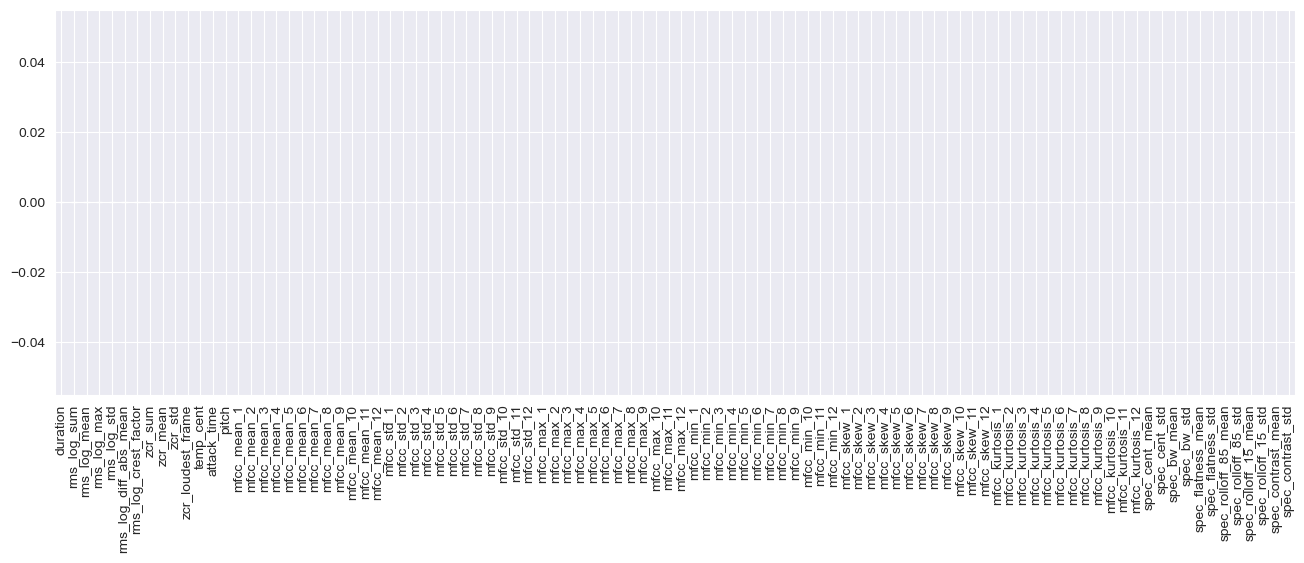

In [19]:
# drop rows with any missing values in features columns
df_drums.dropna(subset=features_columns, inplace=True)
# count missing values per column (in features columns)
df_drums[features_columns].isna().sum().plot(kind='bar', figsize=(16, 5))

### Overview

#### Info

In [20]:
df_drums.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11700 entries, G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Shaker\Shaker (86).wav to G:\Shared drives\PFE - ING3 Mlamali\DrumClassifier - Sounds Dataset\Snap\Wet Snap@augmented__ts_1__ps_1__pi_1__rg_1__ir_1.wav
Data columns (total 104 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    file_name              9436 non-null   object 
 1    file_extension         9436 non-null   object 
 2    class                  11700 non-null  object 
 3    split                  11700 non-null  object 
 4    duration               11700 non-null  float64
 5    rms_log_sum            11700 non-null  float64
 6    rms_log_mean           11700 non-null  float64
 7    rms_log_max            11700 non-null  float64
 8    rms_log_std            11700 non-null  float64
 9    rms_log_diff_abs_mean  11700 non-null  float64
 10   rms_log_crest_factor   11700 non-null  float

#### Describe statistics

In [21]:
df_drums.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,11700.0,1.571637,2.430907,0.046440,0.300000,0.633265,1.782404,32.443175
rms_log_sum,11700.0,-364.247934,748.499208,-19702.312000,-359.308425,-113.256270,-40.871668,19.588580
rms_log_mean,11700.0,-2.171871,1.070426,-16.223179,-2.794473,-2.030056,-1.386566,0.230454
rms_log_max,11700.0,-0.525394,0.319563,-2.445241,-0.682596,-0.501081,-0.280922,0.436995
rms_log_std,11700.0,1.042890,0.572471,0.028278,0.644362,0.933065,1.362522,9.146350
...,...,...,...,...,...,...,...,...
spec_rolloff_85_std,11700.0,2748.999167,2099.135894,0.000000,1021.421799,2274.242288,4106.158119,10482.752616
spec_rolloff_15_mean,11700.0,1416.702901,1585.763885,0.625867,145.973654,903.815515,2132.779522,13330.109579
spec_rolloff_15_std,11700.0,589.528181,771.967572,0.000000,65.188701,336.173919,863.232340,8177.052036
spec_contrast_mean,11700.0,16.505351,3.179344,7.243022,14.357311,15.719740,17.972619,33.921770


The features have high variance and hence need to be normalized

## Train/Test Split Dataset

In [22]:
df_drums.split.value_counts()

train    10291
test      1409
Name: split, dtype: int64

Split into trainset and testset

In [23]:
df_train_augmented = df_drums.query('`split` == "train"').loc[:, features_columns + ["class", "is_augmented"]]
df_train_no_augmented = df_drums.query('`split` == "train" and `is_augmented` == False').loc[:,
                        features_columns + ["class"]]
df_test = df_drums.query('`split` == "test"').loc[:, features_columns + ["class"]]

print(df_train_augmented.shape)
print(df_train_no_augmented.shape)
print(df_test.shape)

(10291, 100)
(8027, 99)
(1409, 99)


## Class distribution

In [24]:
print(f"{df_drums['class'].nunique()} classes")
class_names = df_drums['class'].unique().tolist()
class_names

14 classes


['Shaker',
 'Bell',
 '808',
 'Snap',
 'Kick',
 'Hat Open (Cymbal)',
 'Ride (Cymbal)',
 'Crash (Cymbal)',
 'Hat Closed (Cymbal)',
 'Metal',
 'Conga',
 'Tom',
 'Clap',
 'Snare']

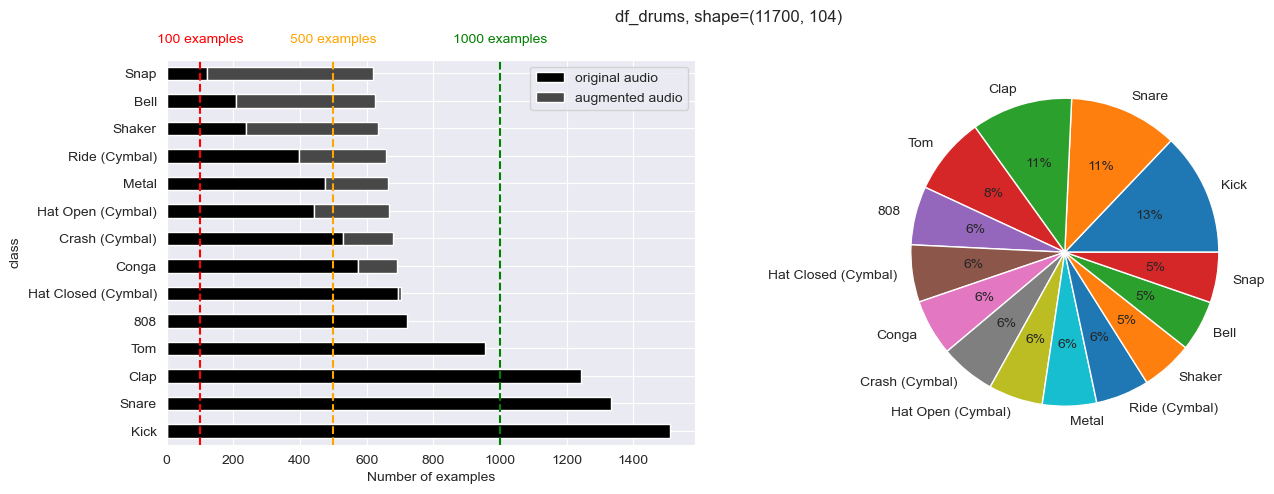

,original audio,augmented audio
class,,
Kick,1509,0
Snare,1333,0
Clap,1242,0
Tom,956,0
808,720,0
Hat Closed (Cymbal),695,8
Conga,573,117
Crash (Cymbal),528,152
Hat Open (Cymbal),442,225


In [25]:
def plot_class_distribution(df, class_column="class", augmented_column=None, figsize=(15, 5), threshold1=100,
                            threshold2=500, threshold3=1000, title=None):
    """
    Plot the distribution of class labels in a dataframe.

    Parameters:
        -- df (pandas DataFrame): The input dataframe.
        -- class_column (str): The name of the column containing the class labels.
        -- figsize (tuple, optional): The size of the figure. Default is (15, 5).
        -- threshold1 (int, optional): The threshold for the first vertical line. Default is 100.
        -- threshold2 (int, optional): The threshold for the second vertical line. Default is 500.
        -- threshold3 (int, optional): The threshold for the third vertical line. Default is 1000.
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    if title:
        fig.suptitle(title)

    if augmented_column is None or augmented_column not in df.columns:
        #print("No augmented column")
        # Plot the bar chart
        df[class_column].value_counts().plot(kind='barh', ax=ax1, color='black')

    else:
        # Count the number of original and augmented examples for each class
        counts = df.groupby([class_column, augmented_column]).size().unstack(fill_value=0)
        # rename columns
        counts.columns = ['original audio', 'augmented audio'] if len(counts.columns) == 2 else ['original audio']
        counts['total'] = counts.sum(axis=1) if len(counts.columns) == 2 else counts['original audio']
        # Trier les valeurs par ordre croissant de count
        counts = counts.sort_values(by=['total', "original audio"], ascending=False)
        counts.drop('total', axis=1, inplace=True)

        # Plot the bar chart
        counts.plot(kind='barh', stacked=True, ax=ax1, color=['black', '#' + "48" * 3])
        ax1.set_xlabel('Number of examples')
        ax1.set_ylabel(class_column)

    # Plot the pie chart
    df[class_column].value_counts().plot(kind='pie', ax=ax2, autopct='%.0f%%')
    ax2.set_ylabel('')

    max_samples_per_class = df[class_column].value_counts().max()
    min_samples_per_class = df[class_column].value_counts().min()

    # vertical lines and text annotations
    h = df[class_column].nunique()
    if threshold1:
        ax1.axvline(threshold1, color='r', linestyle='--')
        ax1.text(threshold1, h, f"{threshold1} examples", fontsize=10, va="bottom", ha="center", color="r")
    if threshold2:
        ax1.axvline(threshold2, color='orange', linestyle='--')
        ax1.text(threshold2, h, f"{threshold2} examples", fontsize=10, va="bottom", ha="center", color="orange")
    if threshold3:
        ax1.axvline(threshold3, color='g', linestyle='--')
        ax1.text(threshold3, h, f"{threshold3} examples", fontsize=10, va="bottom", ha="center", color="g")

    plt.show()

    now_str = datetime.now().strftime("%Y%m%d")
    fig.savefig(
        f"{PROJECT_PATH}/plots/class distribution - {title}, s_per_class=[{min_samples_per_class},{max_samples_per_class}] {now_str}.png",
        bbox_inches='tight')

    return counts if augmented_column is not None else df[class_column].value_counts()


plot_class_distribution(df_drums, title=f"df_drums, shape={df_drums.shape}", augmented_column="is_augmented")

### distribution on train dataset

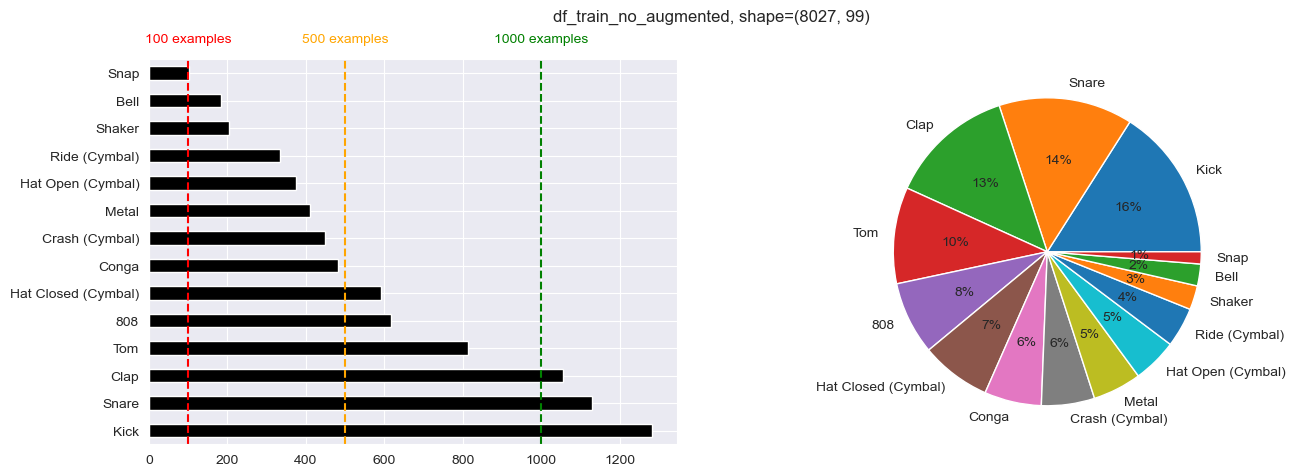

Kick                   1283
Snare                  1130
Clap                   1056
Tom                     813
808                     616
Hat Closed (Cymbal)     592
Conga                   481
Crash (Cymbal)          448
Metal                   410
Hat Open (Cymbal)       374
Ride (Cymbal)           335
Shaker                  203
Bell                    184
Snap                    102
Name: class, dtype: int64

In [26]:
plot_class_distribution(df_train_no_augmented, title=f"df_train_no_augmented, shape={df_train_no_augmented.shape}")

### distribution on train dataset (no augmented audio)

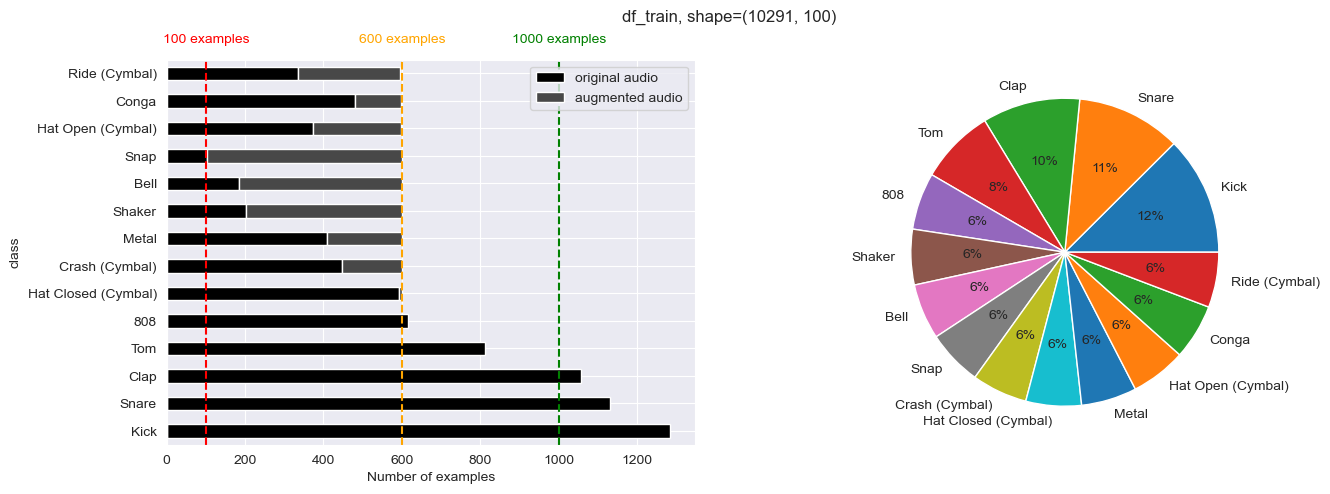

,original audio,augmented audio
class,,
Kick,1283,0
Snare,1130,0
Clap,1056,0
Tom,813,0
808,616,0
Hat Closed (Cymbal),592,8
Crash (Cymbal),448,152
Metal,410,190
Shaker,203,397


In [27]:
plot_class_distribution(df_train_augmented, title=f"df_train, shape={df_train_augmented.shape}",
                        augmented_column="is_augmented", threshold2=600)

### distribution on test dataset

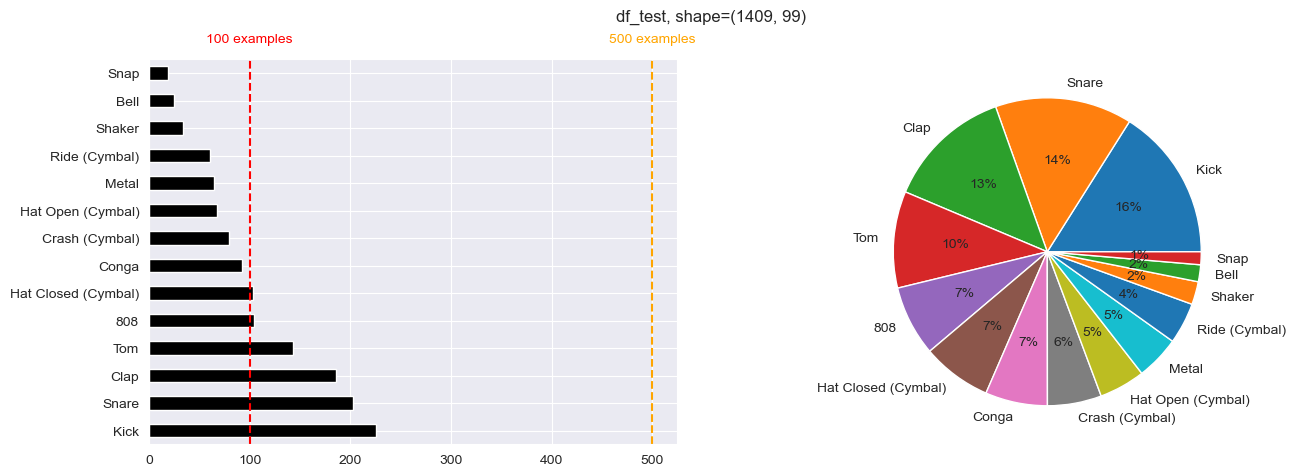

Kick                   226
Snare                  203
Clap                   186
Tom                    143
808                    104
Hat Closed (Cymbal)    103
Conga                   92
Crash (Cymbal)          80
Hat Open (Cymbal)       68
Metal                   65
Ride (Cymbal)           61
Shaker                  34
Bell                    25
Snap                    19
Name: class, dtype: int64

In [28]:
plot_class_distribution(df_test, "class", title=f"df_test, shape={df_test.shape}", threshold3=None)

## Limit the number of examples per class

In [29]:
df_train_augmented["class"].value_counts()

Kick                   1283
Snare                  1130
Clap                   1056
Tom                     813
808                     616
Shaker                  600
Bell                    600
Snap                    600
Crash (Cymbal)          600
Hat Closed (Cymbal)     600
Metal                   600
Hat Open (Cymbal)       599
Conga                   598
Ride (Cymbal)           596
Name: class, dtype: int64

In [30]:
BOOL_LIMIT_N_SAMPLES_PER_CLASS = False

MAX_SAMPLES_PER_CLASS = 30  #todo la c'est 100 mais il faudra mettre 600 puis 1000
MIN_SAMPLES_PER_CLASS, MAX_SAMPLES_PER_CLASS

(600, 30)

In [31]:
def limit_class_size(df, class_column="class", augmented_column="is_augmented", target_number_per_class=500):
    """
    Limits the number of examples per class in a dataframe by randomly removing rows.
    If the number of examples in a class is greater than target_number_per_class,
    augmented examples (if present) are removed first until the target number is reached,
    then original examples are removed randomly to reach the target number.

    Parameters:
        -- df (pandas DataFrame): The input dataframe.
        -- class_column (str, optional): The name of the column containing the class labels. Default is "class".
        -- augmented_column (str, optional): The name of the column containing the augmentation label. Default is "is_augmented".
        -- target_number_per_class (int, optional): The maximum number of examples per class. Default is 500.

    Returns:
        -- The modified dataframe with the limited number of examples per class.
    """

    classes = df[class_column].unique()
    for c in classes:
        df_c = df[df[class_column] == c]
        num_rows = len(df_c)
        if num_rows > target_number_per_class:
            num_augmented_rows = len(df_c[df_c[augmented_column]]) if augmented_column in df_c.columns else 0
            num_original_rows = num_rows - num_augmented_rows
            num_rows_to_remove = num_rows - target_number_per_class
            num_augmented_rows_to_remove = min(num_rows_to_remove, num_augmented_rows)
            num_original_rows_to_remove = num_rows_to_remove - num_augmented_rows_to_remove
            if num_augmented_rows_to_remove > 0 and augmented_column in df_c.columns:
                indices_to_remove = np.random.choice(df_c[df_c[augmented_column]].index,
                                                     size=num_augmented_rows_to_remove, replace=False)
                df = df.drop(indices_to_remove)
            if num_original_rows_to_remove > 0:
                if augmented_column in df_c.columns:
                    indices_to_remove = np.random.choice(df_c[df_c[augmented_column] == False].index,
                                                         size=num_original_rows_to_remove, replace=False)
                else:
                    indices_to_remove = np.random.choice(df_c.index, size=num_original_rows_to_remove, replace=False)

                df = df.drop(indices_to_remove)
    return df


if BOOL_LIMIT_N_SAMPLES_PER_CLASS:
    print("Before limiting class size:")
    plot_class_distribution(df_train_augmented, title=f"df_train_augmented, shape={df_train_augmented.shape}",
                            augmented_column="is_augmented", threshold2=600)
    plot_class_distribution(df_train_no_augmented, title=f"df_train_no_augmented, shape={df_train_no_augmented.shape}")

    print("After limiting class size:")

    df_train_augmented = limit_class_size(df_train_augmented, target_number_per_class=MAX_SAMPLES_PER_CLASS)
    plot_class_distribution(df_train_augmented, title=f"df_train_augmented, shape={df_train_augmented.shape}",
                            augmented_column="is_augmented", threshold2=500)

    df_train_no_augmented = limit_class_size(df_train_no_augmented, target_number_per_class=MAX_SAMPLES_PER_CLASS)
    plot_class_distribution(df_train_no_augmented, title=f"df_train_no_augmented, shape={df_train_no_augmented.shape}")

# Model Building 🔥

## Preprocessing

### Feature selection

In [81]:
PARAMS_TRAIN_SELECT_FEATURES = 1

In [82]:

print(f"{len(features_columns)} features before feature selection : {np.array(features_columns)}")

98 features before feature selection : ['duration' 'rms_log_sum' 'rms_log_mean' 'rms_log_max' 'rms_log_std'
 'rms_log_diff_abs_mean' 'rms_log_crest_factor' 'zcr_sum' 'zcr_mean'
 'zcr_std' 'zcr_loudest_frame' 'temp_cent' 'attack_time' 'pitch'
 'mfcc_mean_1' 'mfcc_mean_2' 'mfcc_mean_3' 'mfcc_mean_4' 'mfcc_mean_5'
 'mfcc_mean_6' 'mfcc_mean_7' 'mfcc_mean_8' 'mfcc_mean_9' 'mfcc_mean_10'
 'mfcc_mean_11' 'mfcc_mean_12' 'mfcc_std_1' 'mfcc_std_2' 'mfcc_std_3'
 'mfcc_std_4' 'mfcc_std_5' 'mfcc_std_6' 'mfcc_std_7' 'mfcc_std_8'
 'mfcc_std_9' 'mfcc_std_10' 'mfcc_std_11' 'mfcc_std_12' 'mfcc_max_1'
 'mfcc_max_2' 'mfcc_max_3' 'mfcc_max_4' 'mfcc_max_5' 'mfcc_max_6'
 'mfcc_max_7' 'mfcc_max_8' 'mfcc_max_9' 'mfcc_max_10' 'mfcc_max_11'
 'mfcc_max_12' 'mfcc_min_1' 'mfcc_min_2' 'mfcc_min_3' 'mfcc_min_4'
 'mfcc_min_5' 'mfcc_min_6' 'mfcc_min_7' 'mfcc_min_8' 'mfcc_min_9'
 'mfcc_min_10' 'mfcc_min_11' 'mfcc_min_12' 'mfcc_skew_1' 'mfcc_skew_2'
 'mfcc_skew_3' 'mfcc_skew_4' 'mfcc_skew_5' 'mfcc_skew_6' 'mfcc_skew_7'
 

Dans l'EDA, nous avons vu que certaines caractéristiques sont corrélées entre elles. Nous allons donc supprimer certaines caractéristiques corrélées pour éviter le surapprentissage.


In [83]:
global_correlate_features_to_delete = ['spec_rolloff_85_mean', 'rms_log_crest_factor', 'mfcc_kurtosis_4',
                                       'mfcc_kurtosis_10', 'zcr_mean', 'mfcc_kurtosis_8', 'mfcc_kurtosis_2',
                                       'mfcc_kurtosis_12', 'mfcc_mean_5', 'mfcc_max_7', 'mfcc_max_9',
                                       'spec_rolloff_85_std', 'rms_log_sum', 'mfcc_max_11', 'mfcc_mean_3',
                                       'mfcc_max_8', 'mfcc_kurtosis_9', 'mfcc_mean_6', 'zcr_loudest_frame',
                                       'mfcc_max_10', 'mfcc_kurtosis_6']

In [84]:
if PARAMS_TRAIN_SELECT_FEATURES == 1:
    features_columns = [x for x in features_columns if x not in global_correlate_features_to_delete]
    print(f"{len(features_columns)} features after feature selection : {np.array(features_columns)}")
elif PARAMS_TRAIN_SELECT_FEATURES == 2:
    # delete all mfcc_kurtosis features
    features_columns = [x for x in features_columns if not x.startswith("mfcc_kurtosis")]
    print(f"{len(features_columns)} features after feature selection : {np.array(features_columns)}")
else:
    print(f"No feature selection")



77 features after feature selection : ['duration' 'rms_log_mean' 'rms_log_max' 'rms_log_std'
 'rms_log_diff_abs_mean' 'zcr_sum' 'zcr_std' 'temp_cent' 'attack_time'
 'pitch' 'mfcc_mean_1' 'mfcc_mean_2' 'mfcc_mean_4' 'mfcc_mean_7'
 'mfcc_mean_8' 'mfcc_mean_9' 'mfcc_mean_10' 'mfcc_mean_11' 'mfcc_mean_12'
 'mfcc_std_1' 'mfcc_std_2' 'mfcc_std_3' 'mfcc_std_4' 'mfcc_std_5'
 'mfcc_std_6' 'mfcc_std_7' 'mfcc_std_8' 'mfcc_std_9' 'mfcc_std_10'
 'mfcc_std_11' 'mfcc_std_12' 'mfcc_max_1' 'mfcc_max_2' 'mfcc_max_3'
 'mfcc_max_4' 'mfcc_max_5' 'mfcc_max_6' 'mfcc_max_12' 'mfcc_min_1'
 'mfcc_min_2' 'mfcc_min_3' 'mfcc_min_4' 'mfcc_min_5' 'mfcc_min_6'
 'mfcc_min_7' 'mfcc_min_8' 'mfcc_min_9' 'mfcc_min_10' 'mfcc_min_11'
 'mfcc_min_12' 'mfcc_skew_1' 'mfcc_skew_2' 'mfcc_skew_3' 'mfcc_skew_4'
 'mfcc_skew_5' 'mfcc_skew_6' 'mfcc_skew_7' 'mfcc_skew_8' 'mfcc_skew_9'
 'mfcc_skew_10' 'mfcc_skew_11' 'mfcc_skew_12' 'mfcc_kurtosis_1'
 'mfcc_kurtosis_3' 'mfcc_kurtosis_5' 'mfcc_kurtosis_7' 'mfcc_kurtosis_11'
 'spec_cent_mea

### Transform (normalize) features

StandardScaler et MinMaxScaler sont deux méthodes populaires de normalisation des données dans le prétraitement des données.

Les avantages de StandardScaler sont qu'elle est robuste aux valeurs extrêmes et qu'elle permet de comparer les données qui suivent une distribution gaussienne. Les inconvénients sont qu'elle peut être sensible aux outliers et qu'elle peut avoir des performances inférieures si les données ne suivent pas une distribution gaussienne.

Les avantages de MinMaxScaler sont qu'elle est simple et facile à comprendre, qu'elle conserve la forme de la distribution originale, et qu'elle est utile pour mettre à l'échelle les données dans des modèles qui utilisent des distances ou des mesures de similarité, comme le clustering ou le nearest neighbor. Les inconvénients sont qu'elle peut être sensible aux valeurs extrêmes et que les données mises à l'échelle peuvent ne pas être centrées sur zéro et avoir une variance unitaire, ce qui peut être un problème pour certains algorithmes.

En résumé, le choix entre StandardScaler et MinMaxScaler dépend du type de données et de l'algorithme utilisé. Il est souvent recommandé de **tester différentes méthodes de normalisation pour trouver celle qui fonctionne le mieux pour les données et l'algorithme en question.**

In [85]:
scaler = MinMaxScaler()
#scaler = StandardScaler()

# On normalise les données de chaque dataframe en utilisant le scaler
df_train_augmented[features_columns] = scaler.fit_transform(df_train_augmented[features_columns])
df_train_no_augmented[features_columns] = scaler.transform(df_train_no_augmented[features_columns])
df_test[features_columns] = scaler.transform(df_test[features_columns])
df_train_augmented.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,10291.00,0.05,0.08,0.00,0.01,0.02,0.05,1.00
rms_log_sum,10291.00,-368.27,736.13,-13825.97,-368.39,-114.56,-41.36,19.59
rms_log_mean,10291.00,0.85,0.06,0.00,0.82,0.86,0.90,1.00
rms_log_max,10291.00,0.66,0.11,0.00,0.61,0.67,0.75,1.00
rms_log_std,10291.00,0.11,0.06,0.00,0.07,0.10,0.15,1.00
...,...,...,...,...,...,...,...,...
spec_rolloff_85_std,10291.00,2754.76,2101.07,0.00,1022.39,2268.39,4121.64,10482.75
spec_rolloff_15_mean,10291.00,0.11,0.12,0.00,0.01,0.07,0.16,1.00
spec_rolloff_15_std,10291.00,0.07,0.09,0.00,0.01,0.04,0.11,1.00
spec_contrast_mean,10291.00,0.35,0.12,0.00,0.27,0.32,0.41,1.00


### Split X and y
Split into input (X) and an output (Y)

In [86]:
y_train_augmented = df_train_augmented["class"]
X_train_augmented = df_train_augmented.drop(["class", "is_augmented"], axis=1).loc[:, features_columns]
print("X_train_augmented", X_train_augmented.shape, "y_train_augmented", y_train_augmented.shape)

y_train_no_augmented = df_train_no_augmented["class"]
X_train_no_augmented = df_train_no_augmented.drop("class", axis=1).loc[:, features_columns]
print("X_train_no_augmented", X_train_no_augmented.shape, "y_train_no_augmented", y_train_no_augmented.shape)

y_test = df_test["class"]
X_test = df_test.drop("class", axis=1).loc[:, features_columns]
print("X_test", X_test.shape, "y_test", y_test.shape)

X_train_augmented (10291, 77) y_train_augmented (10291,)
X_train_no_augmented (8027, 77) y_train_no_augmented (8027,)
X_test (1409, 77) y_test (1409,)


In [87]:
X_train_augmented.columns

Index(['duration', 'rms_log_mean', 'rms_log_max', 'rms_log_std',
       'rms_log_diff_abs_mean', 'zcr_sum', 'zcr_std', 'temp_cent',
       'attack_time', 'pitch', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_4',
       'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10',
       'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_std_1', 'mfcc_std_2',
       'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7',
       'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12',
       'mfcc_max_1', 'mfcc_max_2', 'mfcc_max_3', 'mfcc_max_4', 'mfcc_max_5',
       'mfcc_max_6', 'mfcc_max_12', 'mfcc_min_1', 'mfcc_min_2', 'mfcc_min_3',
       'mfcc_min_4', 'mfcc_min_5', 'mfcc_min_6', 'mfcc_min_7', 'mfcc_min_8',
       'mfcc_min_9', 'mfcc_min_10', 'mfcc_min_11', 'mfcc_min_12',
       'mfcc_skew_1', 'mfcc_skew_2', 'mfcc_skew_3', 'mfcc_skew_4',
       'mfcc_skew_5', 'mfcc_skew_6', 'mfcc_skew_7', 'mfcc_skew_8',
       'mfcc_skew_9', 'mfcc_skew_10', 'mfcc_skew_11', 'mfcc_skew_12'

## train params string

In [88]:
BOOL_LIMIT_N_SAMPLES_PER_CLASS = True

MAX_SAMPLES_PER_CLASS = 600  #todo la c'est 100 mais il faudra mettre 1000
MIN_SAMPLES_PER_CLASS, MAX_SAMPLES_PER_CLASS

(600, 600)

In [89]:
def get_train_params_str(X_train: pd.DataFrame, y_train: pd.DataFrame, augmented: bool = False,
                         features_selected: int = PARAMS_TRAIN_SELECT_FEATURES):
    max_samples_per_class = y_train.value_counts().max()
    min_samples_per_class = y_train.value_counts().min()
    n_features = X_train.shape[1]
    n_samples = X_train.shape[0]

    return f"aug={int(augmented)}, s={n_samples}, s_per_class=[{min_samples_per_class},{max_samples_per_class}], n_feats={n_features}, feat_select={int(features_selected)}"


get_train_params_str(X_train_augmented, y_train_augmented, augmented=True)
TRAIN_PARAMS_STR = get_train_params_str(X_train_no_augmented, y_train_no_augmented, augmented=False)
TRAIN_AUGMENTED_PARAMS_STR = get_train_params_str(X_train_augmented, y_train_augmented, augmented=True)
print(TRAIN_PARAMS_STR)
print(TRAIN_AUGMENTED_PARAMS_STR)

aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1
aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1


## Comment on va comparer nos moèdles ?

Comparer les modèles sur plusieurs métriques, y compris l'accuracy et la f1-score, est une bonne pratique pour évaluer leur performance globale.

En ce qui concerne la validation croisée, cela peut également être une bonne idée, car cela permet de mieux estimer les performances du modèle en utilisant toutes les données disponibles. 

En général, il est recommandé de ne pas inclure les données de test dans la validation croisée et de les réserver pour l'évaluation finale des modèles. Ainsi, pour la validation croisée, vous pouvez utiliser uniquement le jeu de données d'entraînement (y compris les données augmentées si vous décidez de les utiliser) et le jeu de données de validation si vous en avez un.

In [90]:
models_metrics_results = []

> Accuracy

> F1 score

Vous pouvez spécifier le paramètre average pour définir la stratégie de moyenne utilisée pour calculer la métrique. 

- Si toutes vos classes ont la même importance, vous pouvez utiliser "macro". Cela calcule la moyenne non pondérée de la métrique pour chaque classe. C'est donc un bon choix si vous voulez accorder une importance égale à chaque classe.

- Si certaines classes sont plus importantes que d'autres, vous pouvez utiliser "weighted". Cela calcule la moyenne pondérée de la métrique pour chaque classe, en fonction du nombre d'exemples de chaque classe. C'est donc un bon choix si vous voulez accorder plus d'importance aux classes avec plus d'exemples.

- Si vous vous intéressez principalement aux performances globales de votre modèle, vous pouvez utiliser "micro". Cela calcule la métrique globale en prenant en compte chaque prévision et chaque vrai label. C'est donc un bon choix si vous voulez une mesure globale de la performance de votre modèle.

In [141]:
def compute_metrics_results(model_name, model_trained, X_train, y_train, X_test, y_test):
    print(f"Computing metrics for {model_name}...")
    y_pred = model_trained.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=model_trained.classes_, digits=3, output_dict=True)
    print("...")
    accuracy_scores = cross_val_score(model_trained, X_train, y_train, cv=10, scoring="accuracy")
    print("...")
    f1_scores = cross_val_score(model_trained, X_train, y_train, cv=10, scoring=make_scorer(f1_score, average='macro'))

    return {
        "model_name": model_name,
        "model_trained": model_trained,
        "acc_test": accuracy_score(y_test, y_pred),
        "f1_test": f1_score(y_test, y_pred, average='macro'),
        "acc_cv_scores_mean": accuracy_scores.mean(), "acc_cv_scores_std": accuracy_scores.std(),
        "f1_cv_scores_mean": f1_scores.mean(), "f1_cv_scores_std": f1_scores.std()
    }, y_pred, report

## Lazy...


In [92]:
from lazypredict.Supervised import LazyClassifier

clf_lazy = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf_lazy.fit(X_train_augmented, X_test, y_train_augmented, y_test)

clf_lazy_without_aug = LazyClassifier(verbose=0, ignore_warnings=True)
models_without_aug, predictions_without_aug = clf_lazy_without_aug.fit(X_train_no_augmented, X_test,
                                                                       y_train_no_augmented, y_test)

100%|██████████| 29/29 [02:12<00:00,  4.58s/it]


In [93]:
models_without_aug

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.91,0.86,None,0.91,6.88
SVC,0.89,0.83,None,0.88,4.93
LogisticRegression,0.88,0.82,None,0.88,1.04
LinearSVC,0.87,0.81,None,0.87,8.77
RandomForestClassifier,0.89,0.81,None,0.88,20.79
CalibratedClassifierCV,0.87,0.80,None,0.87,31.07
BaggingClassifier,0.85,0.79,None,0.85,19.40
ExtraTreesClassifier,0.87,0.78,None,0.87,3.26
QuadraticDiscriminantAnalysis,0.85,0.78,None,0.84,0.27


In [94]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.91,0.88,None,0.91,5.60
RandomForestClassifier,0.89,0.86,None,0.89,10.11
SVC,0.88,0.83,None,0.88,3.00
ExtraTreesClassifier,0.88,0.82,None,0.87,1.50
LogisticRegression,0.87,0.82,None,0.87,0.69
QuadraticDiscriminantAnalysis,0.84,0.80,None,0.84,0.13
BaggingClassifier,0.84,0.80,None,0.84,8.72
CalibratedClassifierCV,0.85,0.80,None,0.85,17.91
LinearSVC,0.85,0.79,None,0.85,6.23


## 🤖 SVC

### Hyperparameter tuning

In [96]:
# Define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf']
              }

# Define the scoring metric
scorer = make_scorer(f1_score, average='macro')
"""
Le choix de la métrique de performance dépend du problème de classification que vous essayez de résoudre. En général, si les classes sont équilibrées en termes de distribution et d'importance relative, l'accuracy peut être une bonne métrique de performance. Cependant, si les classes sont déséquilibrées ou si certaines classes sont plus importantes que d'autres, alors la f1-score peut être une meilleure métrique car elle prend en compte la précision et le rappel pour chaque classe individuellement.
"""

# Instantiate the SVC model
svc = SVC()

# Instantiate GridSearchCV with the defined parameters and scoring metric
grid_search_svc = GridSearchCV(svc, param_grid=param_grid, scoring=scorer, verbose=1, n_jobs=-1)

### Fit on the train data

In [97]:
# Fit the GridSearchCV object on the training data
grid_search_svc.fit(X_train_no_augmented, y_train_no_augmented)

# Print the best parameters and best score
print("Best parameters: ", grid_search_svc.best_params_)
print("Best score: ", grid_search_svc.best_score_)

# Make predictions on the test data using the best model
best_svc_no_augmented = grid_search_svc.best_estimator_
best_svc_no_augmented

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.8118120635720004


SVC(C=10, gamma=1)

### Fit on augmented data

In [98]:
# Fit the GridSearchCV object on the training data
grid_search_svc.fit(X_train_augmented, y_train_augmented)

# Print the best parameters and best score
print("Best parameters: ", grid_search_svc.best_params_)
print("Best score: ", grid_search_svc.best_score_)

# Make predictions on the test data using the best model
best_svc_augmented = grid_search_svc.best_estimator_
best_svc_augmented

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  0.8373456206306782


SVC(C=100, gamma=0.1)

### ✅ Evaluation

In [140]:
scores, y_pred_svc_no_augmented, report_svc_no_augmented = compute_metrics_results(f"SCV data[{TRAIN_PARAMS_STR}]",
                                                                                   best_svc_no_augmented,
                                                                                   X_train_no_augmented,
                                                                                   y_train_no_augmented, X_test, y_test)
models_metrics_results.append(scores)

{'808': {'precision': 0.9611650485436893, 'recall': 0.9519230769230769, 'f1-score': 0.9565217391304348, 'support': 104}, 'Bell': {'precision': 0.8076923076923077, 'recall': 0.84, 'f1-score': 0.8235294117647058, 'support': 25}, 'Clap': {'precision': 0.9267015706806283, 'recall': 0.9516129032258065, 'f1-score': 0.9389920424403183, 'support': 186}, 'Conga': {'precision': 0.9310344827586207, 'recall': 0.8804347826086957, 'f1-score': 0.9050279329608939, 'support': 92}, 'Crash (Cymbal)': {'precision': 0.775, 'recall': 0.775, 'f1-score': 0.775, 'support': 80}, 'Hat Closed (Cymbal)': {'precision': 0.883495145631068, 'recall': 0.883495145631068, 'f1-score': 0.883495145631068, 'support': 103}, 'Hat Open (Cymbal)': {'precision': 0.7971014492753623, 'recall': 0.8088235294117647, 'f1-score': 0.8029197080291971, 'support': 68}, 'Kick': {'precision': 0.9106382978723404, 'recall': 0.9469026548672567, 'f1-score': 0.9284164859002169, 'support': 226}, 'Metal': {'precision': 0.9375, 'recall': 0.9230769230

KeyError: 'f1_test'

In [164]:
def report_dict_to_df(report_dict):
    df_report = pd.DataFrame(report_dict).transpose()
    accuracy_rows = df_report[df_report.index.str.contains('accuracy|macro avg|weighted avg')]
    df_report.drop(accuracy_rows.index, inplace=True)
    df_report.sort_values(by=['f1-score'], ascending=False, inplace=True)
    df_report = df_report.append(accuracy_rows)
    df_report = df_report.astype({'support': 'int32'})
    return df_report

# save report
def display_report(report,model_name,params_str):
    # convert to dataframe
    df_report = report_dict_to_df(report)

    #df_report_ = df_report.style.background_gradient(axis=None, vmin=0.6, vmax=1.0)
    df_report_ = df_report.style.background_gradient(axis=None, vmin=0.6, vmax=1.0, subset=df_report.columns[:3])
    # change color background for only f1-score column
    # save
    now_str = datetime.now().strftime("%Y%m%d")
    output_file_path = f'{PROJECT_PATH}/plots/{now_str} Report - {model_name} data[{params_str}].png'
    dfi.export(df_report_, output_file_path)
    return df_report_


display_report(report_svc_no_augmented,'SVC',TRAIN_PARAMS_STR)

,precision,recall,f1-score,support
808,0.961165,0.951923,0.956522,104
Snare,0.932692,0.955665,0.944039,203
Clap,0.926702,0.951613,0.938992,186
Metal,0.937500,0.923077,0.930233,65
Kick,0.910638,0.946903,0.928416,226
Conga,0.931034,0.880435,0.905028,92
Hat Closed (Cymbal),0.883495,0.883495,0.883495,103
Tom,0.876812,0.846154,0.861210,143
Bell,0.807692,0.840000,0.823529,25
Hat Open (Cymbal),0.797101,0.808824,0.802920,68


In [161]:
scores, y_pred_svc_augmented, report_svc_augmented = compute_metrics_results(f"SCV data[{TRAIN_AUGMENTED_PARAMS_STR}]",
                                                                             best_svc_augmented, X_train_augmented,
                                                                             y_train_augmented, X_test, y_test)
models_metrics_results.append(scores)
display_report(report_svc_augmented,'SVC',TRAIN_AUGMENTED_PARAMS_STR)

Computing metrics for SCV data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]...
...
...
              precision  recall  f1-score  support
accuracy           0.89    0.89      0.89     0.89
macro avg          0.85    0.84      0.84  1409.00
weighted avg       0.89    0.89      0.89  1409.00


,precision,recall,f1-score,support
808,0.970874,0.961538,0.966184,104
Metal,0.926471,0.969231,0.947368,65
Snare,0.940887,0.940887,0.940887,203
Clap,0.925926,0.940860,0.933333,186
Kick,0.902954,0.946903,0.924406,226
Conga,0.884211,0.913043,0.898396,92
Hat Closed (Cymbal),0.888889,0.854369,0.871287,103
Tom,0.900000,0.818182,0.857143,143
Bell,0.909091,0.800000,0.851064,25
Hat Open (Cymbal),0.797101,0.808824,0.802920,68


#### Confusion Matrix

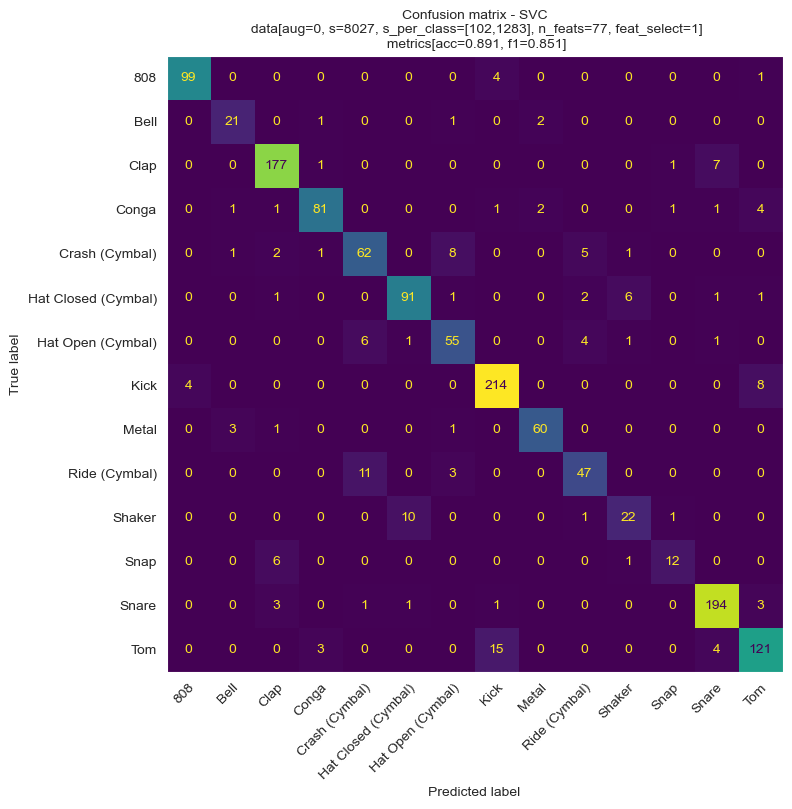

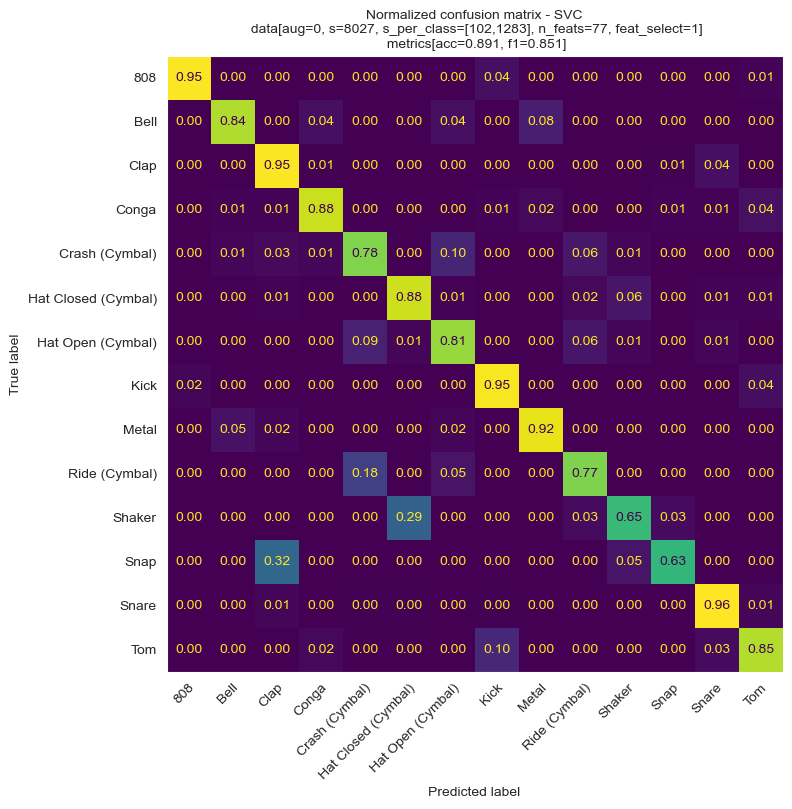

In [101]:
def plot_confusion_matrix_(y_test, y_pred, display_labels, normalize=False, title=None, save=True,
                           train_params_str=None):
    cm = confusion_matrix(y_test, y_pred, normalize='true' if normalize else None)
    cmp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
    s = 8
    fig, ax = plt.subplots(figsize=(s, s))
    cmp.plot(ax=ax, colorbar=False,
             values_format=".2f" if normalize else None)  #, xticks_rotation='vertical', cmap=plt.cm.Blues

    title__ = "Normalized confusion matrix" if normalize else "Confusion matrix"
    if title:
        title__ += f" - {title}"

    if train_params_str:
        title__ += f"\n data[{train_params_str}]"

    title__ += f"\n metrics[acc={accuracy_score(y_test, y_pred):.3f}, f1={f1_score(y_test, y_pred, average='macro'):.3f}]"

    cmp.ax_.set_title(title__, fontsize=10)
    plt.grid(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

    # save figure
    if save:
        now_str = datetime.now().strftime("%Y%m%d")
        title__ = title__.replace("\n", " ")
        fig.savefig(f"{PROJECT_PATH}/plots/{now_str} {title__}.png", bbox_inches='tight')


# plot no normalized confusion matrix and normalized confusion matrix
def plot_confusion_matrix(y_test, y_pred, display_labels, normalize=None, title=None, save=True, train_params_str=None):
    for normalize in [False, True]:
        plot_confusion_matrix_(y_test, y_pred, display_labels, normalize=normalize, title=title, save=save,
                               train_params_str=train_params_str)


plot_confusion_matrix(y_test, y_pred_svc_no_augmented, display_labels=best_svc_no_augmented.classes_, normalize=False,
                      title=f"SVC", save=True, train_params_str=TRAIN_PARAMS_STR)

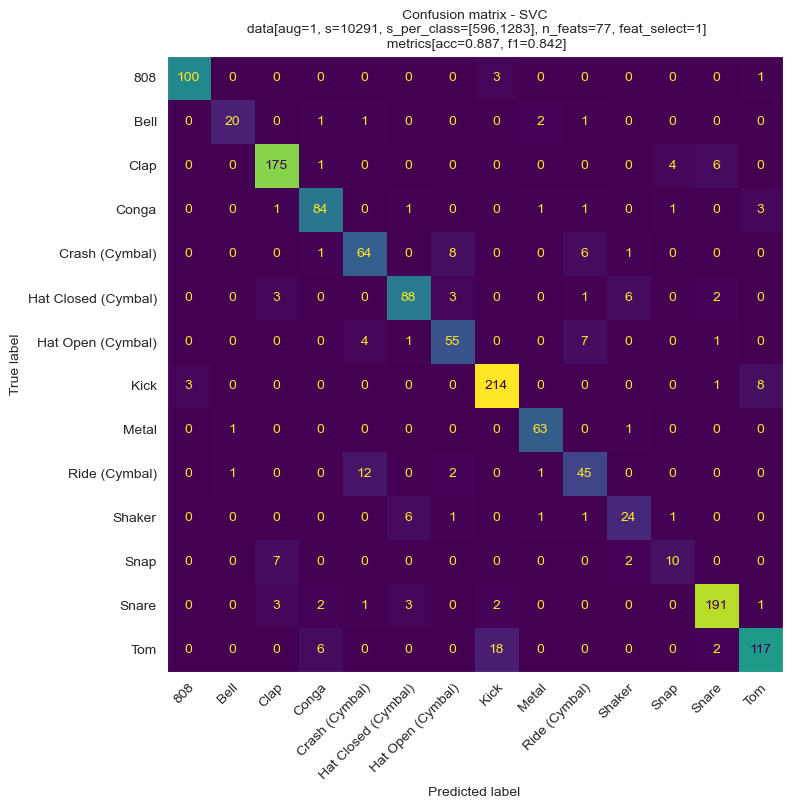

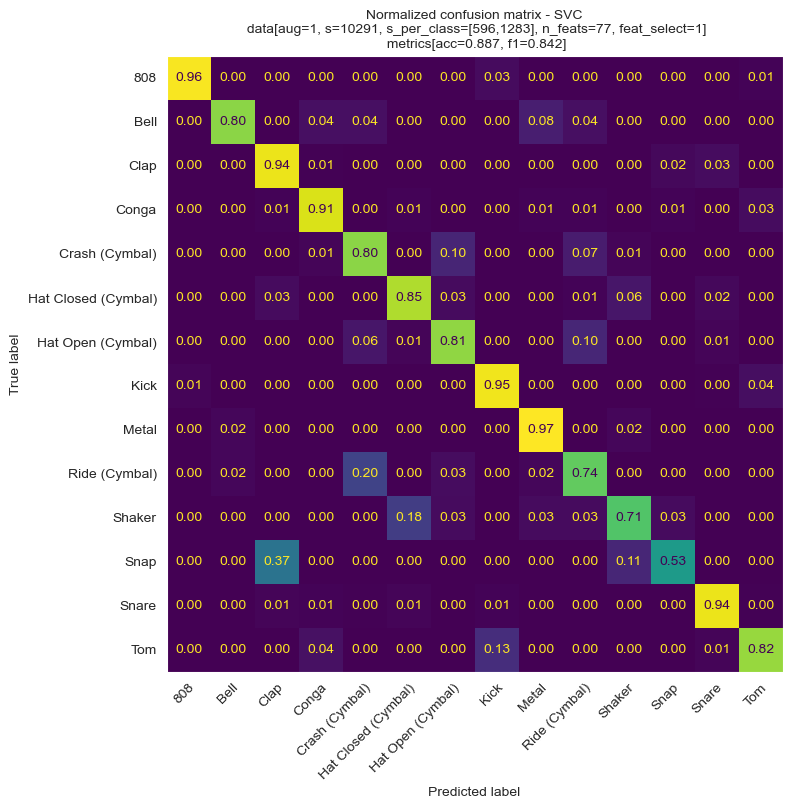

In [102]:
plot_confusion_matrix(y_test, y_pred_svc_augmented, display_labels=best_svc_augmented.classes_, normalize=False,
                      title=f"SVC", save=True, train_params_str=TRAIN_AUGMENTED_PARAMS_STR)

#### Report comparison (with and without augmentation)

In [ ]:
def compare_classification_reports(report1 : dict, report2 : dict , model_name, train_params_str = TRAIN_PARAMS_STR, train_augmented_params_str = TRAIN_AUGMENTED_PARAMS_STR):
    # to dataframe
    df_report1 = report_dict_to_df(report1)
    df_report2 = report_dict_to_df(report2)

    # make the comparison
    df_diff = df_report1 - df_report2
    df_diff = df_diff.replace({0: np.nan})

    v = 0.3
    df_diff_ = df_diff.style.background_gradient(axis=None, cmap='cool', vmin=-v, vmax=v)
    # save
    now_str = datetime.now().strftime("%Y%m%d")
    output_file_path = f'{PROJECT_PATH}/plots/{now_str} Report comparison no_aug vs. aug - {model_name} data[{train_params_str}]+data[{train_augmented_params_str}].png'
    dfi.export(df_diff_, output_file_path)
    return df_diff_


reports_comparison_svc_df = compare_classification_reports(report_svc_no_augmented, report_svc_augmented, 'SVC')
reports_comparison_svc_df

On remarque que le

#### Cross validation scores

In [104]:
models_metrics_results[-2:]

[{'model_name': 'SCV data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1]',
  'model_trained': SVC(C=10, gamma=1),
  'acc_test': 0.8914123491838183,
  'f1_test': 0.8511087629319397,
  'acc_cv_scores_mean': 0.878296320220619,
  'acc_cv_scores_std': 0.035248770793380235,
  'f1_cv_scores_mean': 0.8244333068180273,
  'f1_cv_scores_std': 0.052151866358295225},
 {'model_name': 'SCV data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]',
  'model_trained': SVC(C=100, gamma=0.1),
  'acc_test': 0.8871540099361249,
  'f1_test': 0.8422949300085083,
  'acc_cv_scores_mean': 0.8651324219007991,
  'acc_cv_scores_std': 0.0400637927829832,
  'f1_cv_scores_mean': 0.8536140451642871,
  'f1_cv_scores_std': 0.046953364399817565}]

### Variables Importance

In [105]:
# todo

### 💾 Save model

In [106]:
def save_ml_model(model, model_name, scaler, features_columns):
    model_output_path = f"models/{model_name} {datetime.now().strftime('%Y%m%d_%H')}.pkl"
    with open(model_output_path, 'wb') as f:
        # save the model, the scaler and the features columns names
        pickle.dump(model, f)
        pickle.dump(scaler, f)
        pickle.dump(features_columns, f)
        print(f"> saved successfully '{model_output_path}'")


def get_saved_models():
    models = []
    for file in os.listdir("models/"):
        if file.endswith(".pkl"):
            models.append(file)
    return models


def print_saved_models():
    models = get_saved_models()
    if len(models) == 0:
        print("No saved models")
    else:
        print("Saved models:")
        for i, model in enumerate(models):
            print(f"{i + 1}. {model}")


def load_ml_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model '{model_path}' not found")

    with open(model_path, 'rb') as f:
        # save the model, the scaler and the features columns names
        model = pickle.load(f)
        scaler = pickle.load(f)
        features_columns = pickle.load(f)
        print(f"> '{model_path}' loaded successfully")
        print(f">>> Model: {model}")
        print(f">>> Scaler: {scaler}")
        print(f">>> {len(features_columns)} Features columns: {features_columns[:5]} ... {features_columns[-5:]}")

        return model, scaler, features_columns

In [107]:
save_ml_model(model=best_svc_no_augmented, model_name=f"SVC data[{TRAIN_PARAMS_STR}]", scaler=scaler,
              features_columns=features_columns)
save_ml_model(model=best_svc_augmented, model_name=f"SVC data[{TRAIN_AUGMENTED_PARAMS_STR}]", scaler=scaler,
              features_columns=features_columns)

> saved successfully 'models/SVC data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1] 20230514_00.pkl'
> saved successfully 'models/SVC data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1] 20230514_00.pkl'


In [108]:
model__, scaler__, features_columns__ = load_ml_model(
    "models/SVC data[aug=1, s=8393, s_per_class=[596,600], n_feats=98, feat_select=0] 20230512_21.pkl")
model__, scaler__, features_columns__

> 'models/SVC data[aug=1, s=8393, s_per_class=[596,600], n_feats=98, feat_select=0] 20230512_21.pkl' loaded successfully
>>> Model: SVC(C=100, gamma=0.1)
>>> Scaler: MinMaxScaler()
>>> 98 Features columns: ['duration', 'rms_log_sum', 'rms_log_mean', 'rms_log_max', 'rms_log_std'] ... ['spec_rolloff_85_std', 'spec_rolloff_15_mean', 'spec_rolloff_15_std', 'spec_contrast_mean', 'spec_contrast_std']


(SVC(C=100, gamma=0.1),
 MinMaxScaler(),
 ['duration',
  'rms_log_sum',
  'rms_log_mean',
  'rms_log_max',
  'rms_log_std',
  'rms_log_diff_abs_mean',
  'rms_log_crest_factor',
  'zcr_sum',
  'zcr_mean',
  'zcr_std',
  'zcr_loudest_frame',
  'temp_cent',
  'attack_time',
  'pitch',
  'mfcc_mean_1',
  'mfcc_mean_2',
  'mfcc_mean_3',
  'mfcc_mean_4',
  'mfcc_mean_5',
  'mfcc_mean_6',
  'mfcc_mean_7',
  'mfcc_mean_8',
  'mfcc_mean_9',
  'mfcc_mean_10',
  'mfcc_mean_11',
  'mfcc_mean_12',
  'mfcc_std_1',
  'mfcc_std_2',
  'mfcc_std_3',
  'mfcc_std_4',
  'mfcc_std_5',
  'mfcc_std_6',
  'mfcc_std_7',
  'mfcc_std_8',
  'mfcc_std_9',
  'mfcc_std_10',
  'mfcc_std_11',
  'mfcc_std_12',
  'mfcc_max_1',
  'mfcc_max_2',
  'mfcc_max_3',
  'mfcc_max_4',
  'mfcc_max_5',
  'mfcc_max_6',
  'mfcc_max_7',
  'mfcc_max_8',
  'mfcc_max_9',
  'mfcc_max_10',
  'mfcc_max_11',
  'mfcc_max_12',
  'mfcc_min_1',
  'mfcc_min_2',
  'mfcc_min_3',
  'mfcc_min_4',
  'mfcc_min_5',
  'mfcc_min_6',
  'mfcc_min_7',
  'mfcc_

## 🤖 RandomForestClassifier

### Hyperparameters tuning

In [109]:
# Define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 500],
              'max_depth': [10, 20, 30, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}

# Define the scoring metric
scorer = make_scorer(f1_score, average='macro')

# Instantiate the Random Forest model
rf = RandomForestClassifier()

# Instantiate GridSearchCV with the defined parameters and scoring metric
grid_search_rf = GridSearchCV(rf, param_grid=param_grid, scoring=scorer, verbose=1, n_jobs=-1)

### Fit on train data

In [110]:
# Fit the GridSearchCV object on the training data
grid_search_rf.fit(X_train_no_augmented, y_train_no_augmented)

# Print the best parameters and best score
print("Best parameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)

# Make predictions on the test data using the best model
best_rf_no_augmented = grid_search_rf.best_estimator_
best_rf_no_augmented

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.7972573543560223


RandomForestClassifier(max_depth=30, n_estimators=200)

### Fit on augmented data

In [111]:
# Fit the GridSearchCV object on the training data
grid_search_rf.fit(X_train_augmented, y_train_augmented)

# Print the best parameters and best score
print("Best parameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)

# Make predictions on the test data using the best model
best_rf_augmented = grid_search_rf.best_estimator_
best_rf_augmented

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.8315597490565836


RandomForestClassifier(max_features='auto', n_estimators=500)

### ✅ Evaluation

In [169]:
scores, y_pred_rf_no_augmented, report_rf_no_augmented = compute_metrics_results(
    f"RandomForest data[{TRAIN_PARAMS_STR}]", best_rf_no_augmented, X_train_no_augmented, y_train_no_augmented, X_test,
    y_test)

# Add the scores and the model name to the list
models_metrics_results.append(scores)

# Print the classification report
display_report(report_rf_no_augmented)

Computing metrics for RandomForest data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1]...
...
...


TypeError: display_report() missing 2 required positional arguments: 'model_name' and 'params_str'

In [ ]:
scores, y_pred_rf_augmented, report_rf_augmented = compute_metrics_results(
    f"RandomForest data[{TRAIN_AUGMENTED_PARAMS_STR}]", best_rf_augmented, X_train_augmented, y_train_augmented, X_test,
    y_test)

# Add the scores and the model name to the list
models_metrics_results.append(scores)

# Print the classification report
display_report(report_rf_augmented)

#### Confusion matrix

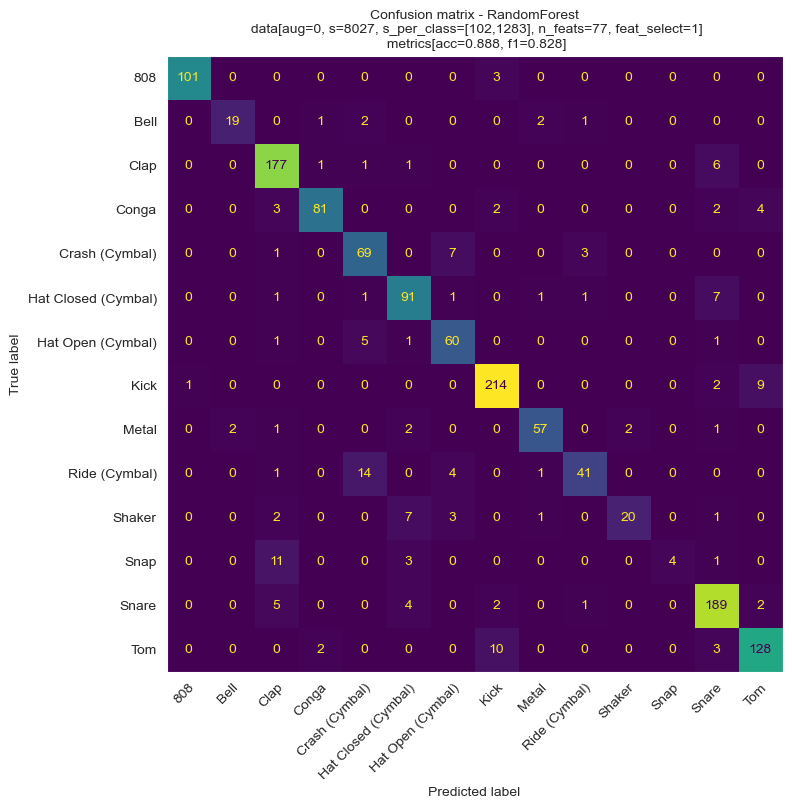

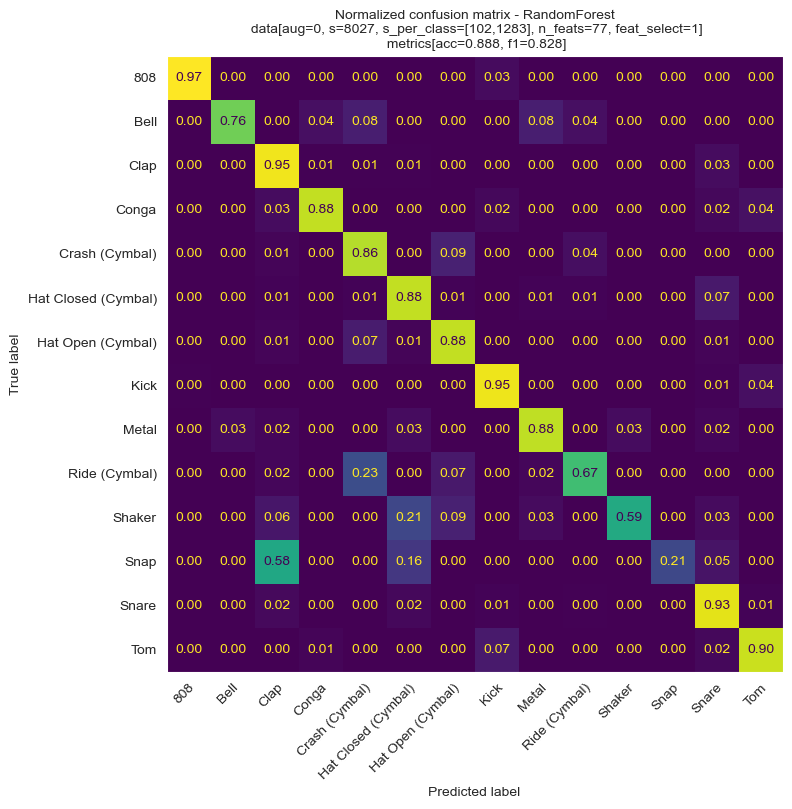

In [114]:
plot_confusion_matrix(y_test, y_pred_rf_no_augmented, display_labels=best_rf_no_augmented.classes_, normalize=False,
                      title=f"RandomForest", save=True, train_params_str=TRAIN_PARAMS_STR)

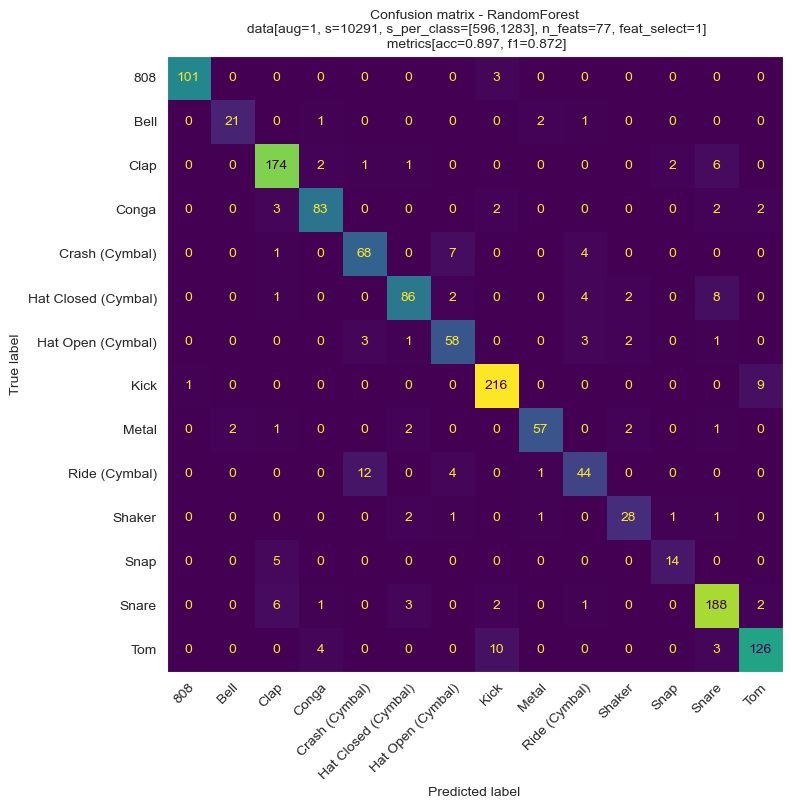

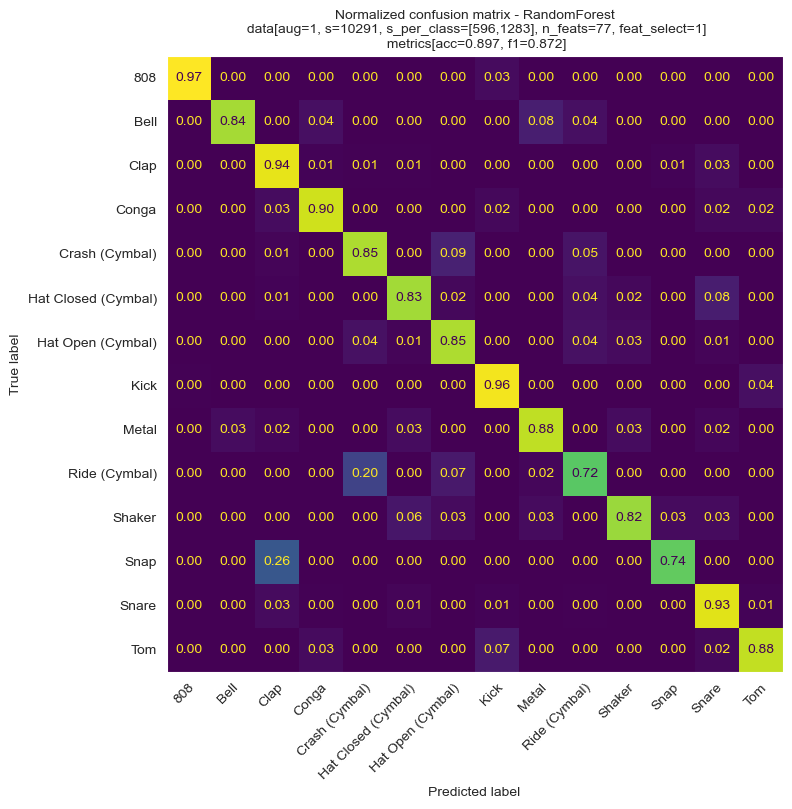

In [115]:
plot_confusion_matrix(y_test, y_pred_rf_augmented, display_labels=best_rf_augmented.classes_, normalize=False,
                      title=f"RandomForest", save=True, train_params_str=TRAIN_AUGMENTED_PARAMS_STR)

#### Report comparison (with/without augmented trainset)

In [116]:
reports_comparison_rf_df = compare_classification_reports(report_rf_no_augmented, report_rf_augmented,
                                                          model_name="RandomForest")
reports_comparison_rf_df

,precision,recall,f1-score
808,nan,nan,nan
Bell,0.008000,0.080000,0.049000
Clap,0.039000,-0.017000,0.013000
Conga,-0.041000,0.022000,-0.008000
Crash (Cymbal),0.060000,-0.013000,0.027000
Hat Closed (Cymbal),0.070000,-0.048000,0.011000
Hat Open (Cymbal),0.006000,-0.029000,-0.010000
Kick,0.001000,0.009000,0.004000
Metal,0.015000,nan,0.007000
Ride (Cymbal),-0.100000,0.049000,-0.013000


#### Cross validation scores

In [117]:
models_metrics_results[-2:]

[{'model_name': 'RandomForest data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1]',
  'model_trained': RandomForestClassifier(max_depth=30, n_estimators=200),
  'acc_test': 0.8878637331440739,
  'f1_test': 0.8279454770168992,
  'acc_cv_scores_mean': 0.8713164163066803,
  'acc_cv_scores_std': 0.022180275408605985,
  'f1_cv_scores_mean': 0.8122710305894854,
  'f1_cv_scores_std': 0.03012339498477973},
 {'model_name': 'RandomForest data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]',
  'model_trained': RandomForestClassifier(max_features='auto', n_estimators=500),
  'acc_test': 0.8970901348474095,
  'f1_test': 0.8720947701954472,
  'acc_cv_scores_mean': 0.8544384688688236,
  'acc_cv_scores_std': 0.03488306783589241,
  'f1_cv_scores_mean': 0.8443286096554112,
  'f1_cv_scores_std': 0.03945872425666299}]

### Variables Importance

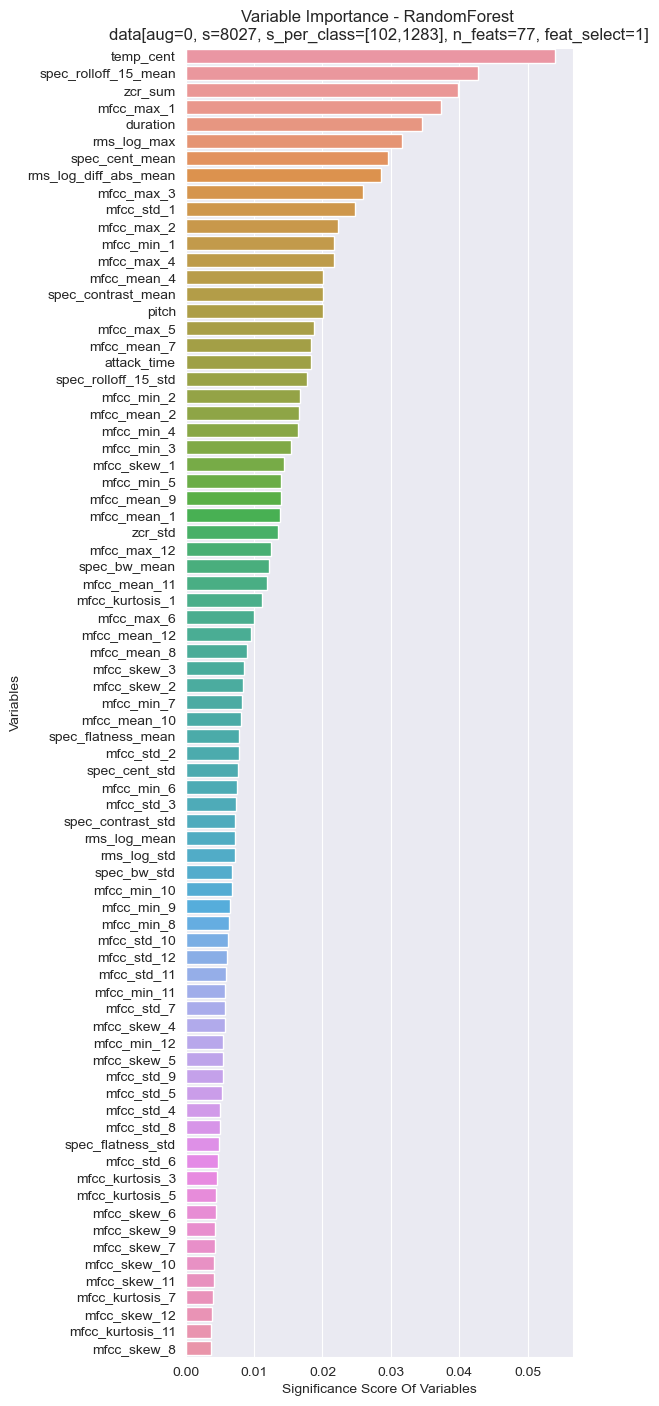

#################### head ####################
temp_cent               0.05
spec_rolloff_15_mean    0.04
zcr_sum                 0.04
mfcc_max_1              0.04
duration                0.03
rms_log_max             0.03
spec_cent_mean          0.03
rms_log_diff_abs_mean   0.03
mfcc_max_3              0.03
mfcc_std_1              0.02
dtype: float64
#################### tail ####################
mfcc_kurtosis_5    0.00
mfcc_skew_6        0.00
mfcc_skew_9        0.00
mfcc_skew_7        0.00
mfcc_skew_10       0.00
mfcc_skew_11       0.00
mfcc_kurtosis_7    0.00
mfcc_skew_12       0.00
mfcc_kurtosis_11   0.00
mfcc_skew_8        0.00
dtype: float64


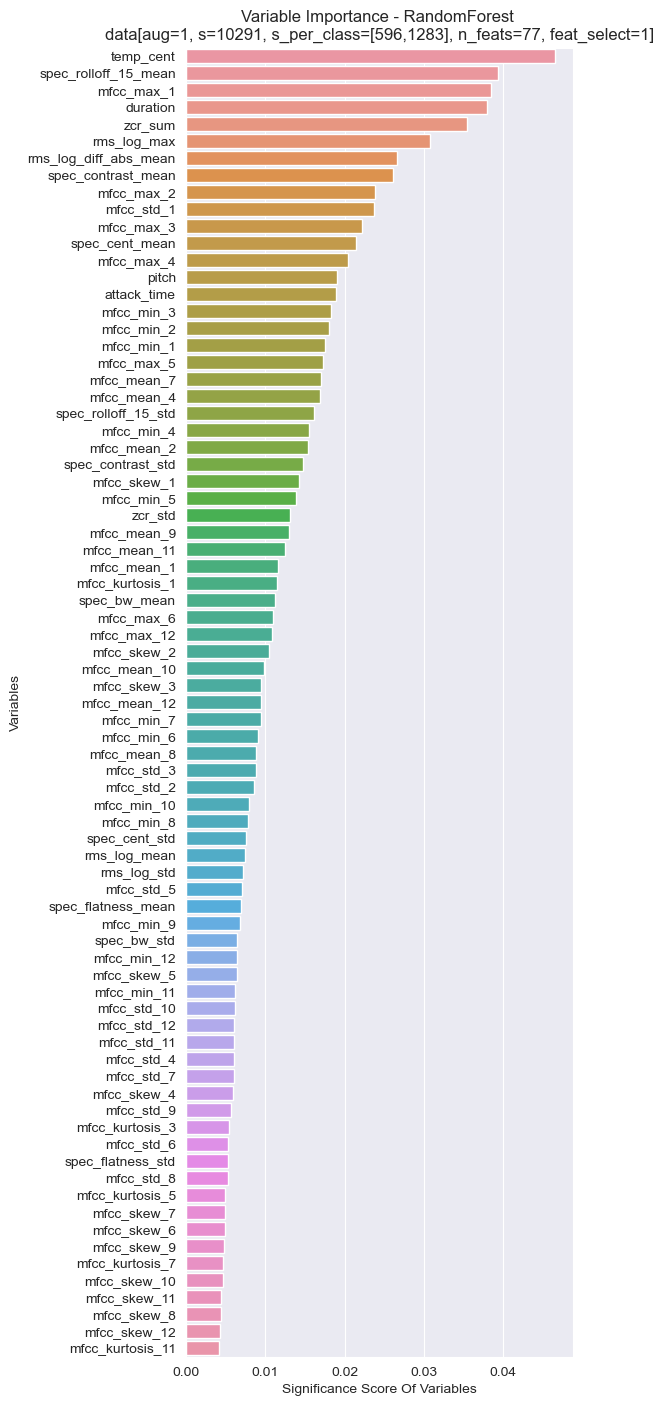

#################### head ####################
temp_cent               0.05
spec_rolloff_15_mean    0.04
mfcc_max_1              0.04
duration                0.04
zcr_sum                 0.04
rms_log_max             0.03
rms_log_diff_abs_mean   0.03
spec_contrast_mean      0.03
mfcc_max_2              0.02
mfcc_std_1              0.02
dtype: float64
#################### tail ####################
mfcc_kurtosis_5    0.00
mfcc_skew_7        0.00
mfcc_skew_6        0.00
mfcc_skew_9        0.00
mfcc_kurtosis_7    0.00
mfcc_skew_10       0.00
mfcc_skew_11       0.00
mfcc_skew_8        0.00
mfcc_skew_12       0.00
mfcc_kurtosis_11   0.00
dtype: float64


In [118]:
for model, X_train, train_params in [(best_rf_no_augmented, X_train_no_augmented, TRAIN_PARAMS_STR),
                                     (best_rf_augmented, X_train_augmented, TRAIN_AUGMENTED_PARAMS_STR)]:
    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    # barplot of feature importances (horizontal barchart)
    fig = plt.figure(figsize=(5, 17))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Significance Score Of Variables')
    plt.ylabel('Variables')
    title = f"Variable Importance - RandomForest \ndata[{train_params}]"
    plt.title(title)
    plt.show()
    # prinr head and tail of feature importances
    print("#" * 20, "head", "#" * 20)
    print(feature_imp.head(10))
    print("#" * 20, "tail", "#" * 20)
    print(feature_imp.tail(10))

    # save figure
    now_str = datetime.now().strftime("%Y%m%d")
    title = title.replace("\n", " ")
    fig.savefig(f"{PROJECT_PATH}/plots/{now_str} {title}.png", bbox_inches='tight')

### 💾 Save model

In [119]:
save_ml_model(model=best_rf_no_augmented, model_name=f"RandomForest data[{TRAIN_PARAMS_STR}]", scaler=scaler,
              features_columns=features_columns)
save_ml_model(model=best_rf_augmented, model_name=f"RandomForest data[{TRAIN_AUGMENTED_PARAMS_STR}]", scaler=scaler,
              features_columns=features_columns)


> saved successfully 'models/RandomForest data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1] 20230514_04.pkl'
> saved successfully 'models/RandomForest data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1] 20230514_04.pkl'


## 🤖 LGBMClassifier

### Hyperparameters tuning

In [120]:
# Define the parameter grid to search over
params_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    #'num_leaves': [31, 63],
    #'min_child_samples': [20, 50],
    #'subsample': [0.8, 1],
    #'colsample_bytree': [0.8, 1],
}

# Define the scoring metric
scorer = make_scorer(f1_score, average='macro')

# Instantiate the LGBMClassifier model
lgbm = LGBMClassifier()

# Instantiate GridSearchCV with the defined parameters and scoring metric
grid_search_lgbm = GridSearchCV(lgbm, param_grid=param_grid, scoring=scorer, verbose=1, n_jobs=-1)


### Fit on train data

In [121]:
# Fit the GridSearchCV object on the training data
grid_search_lgbm.fit(X_train_no_augmented, y_train_no_augmented)

# Print the best parameters and best score
print("Best parameters: ", grid_search_lgbm.best_params_)
print("Best score: ", grid_search_lgbm.best_score_)

# Make predictions on the test data using the best model
best_lgbm_no_augmented = grid_search_lgbm.best_estimator_
best_lgbm_no_augmented

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
Best parameters:  {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.8432497043231739


LGBMClassifier(max_depth=30, max_features='auto', min_samples_leaf=4,
               min_samples_split=2, n_estimators=200)

### Fit on augmented data

In [122]:
# Fit the GridSearchCV object on the training data
grid_search_lgbm.fit(X_train_augmented, y_train_augmented)

# Print the best parameters and best score
print("Best parameters: ", grid_search_lgbm.best_params_)
print("Best score: ", grid_search_lgbm.best_score_)

# Make predictions on the test data using the best model
best_lgbm_augmented = grid_search_lgbm.best_estimator_
best_lgbm_augmented

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.8638522242274105


LGBMClassifier(max_depth=20, max_features='auto', min_samples_leaf=4,
               min_samples_split=2, n_estimators=500)

### ✅ Evaluation

In [123]:
cores, y_pred_lgbm_no_augmented, report_lgbm_no_augmented = compute_metrics_results(f"LGBM data[{TRAIN_PARAMS_STR}]",
                                                                                    best_lgbm_no_augmented,
                                                                                    X_train_no_augmented,
                                                                                    y_train_no_augmented, X_test,
                                                                                    y_test)

# Add the scores and the model name to the list
models_metrics_results.append(scores)

# Print the classification report
display_report(report_lgbm_no_augmented)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] U

In [124]:

scores, y_pred_lgbm_augmented, report_lgbm_augmented = compute_metrics_results(
    f"LGBM data[{TRAIN_AUGMENTED_PARAMS_STR}]", best_lgbm_augmented, X_train_augmented, y_train_augmented, X_test,
    y_test)

# Add the scores and the model name to the list
models_metrics_results.append(scores)

# Print the classification report
display_report(report_lgbm_augmented)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] U

#### Confusion matrix

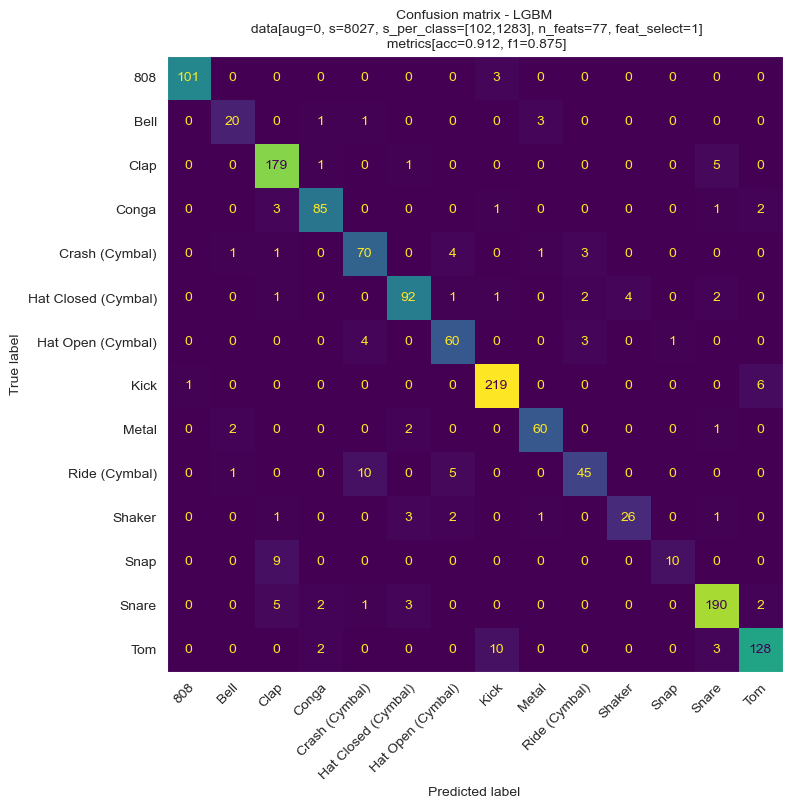

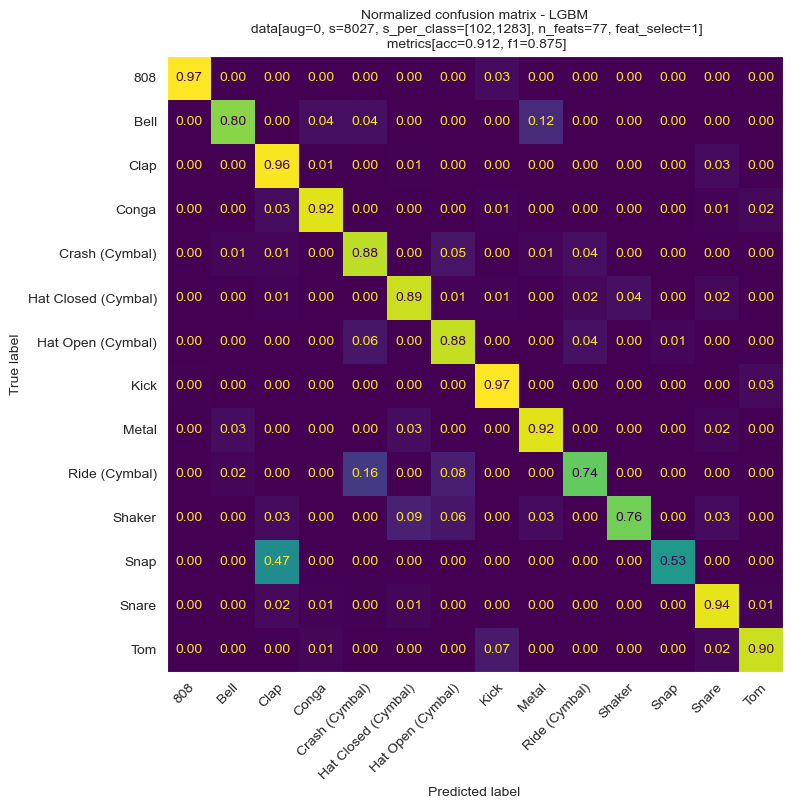

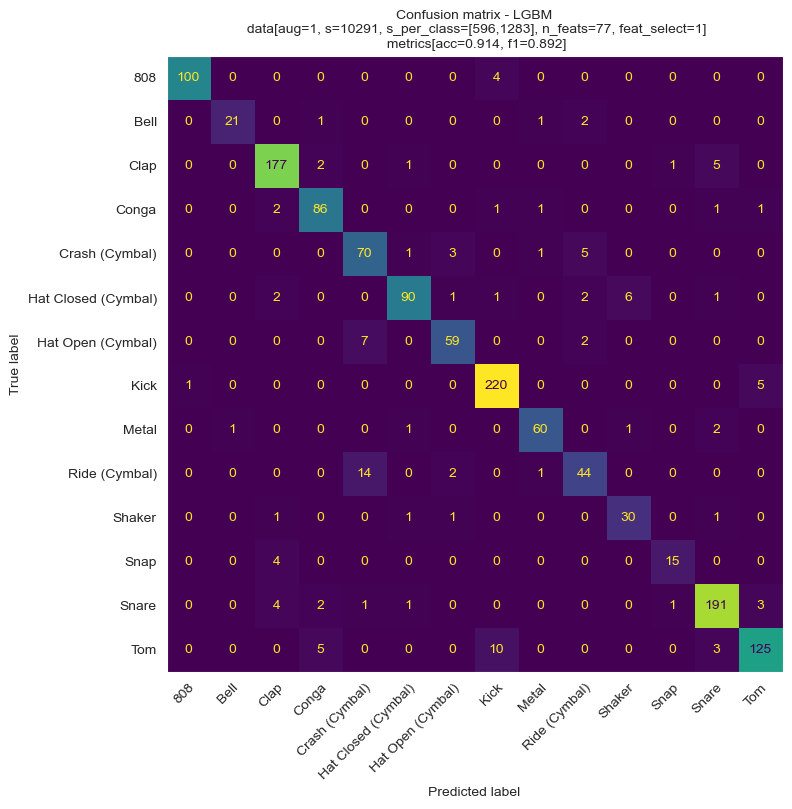

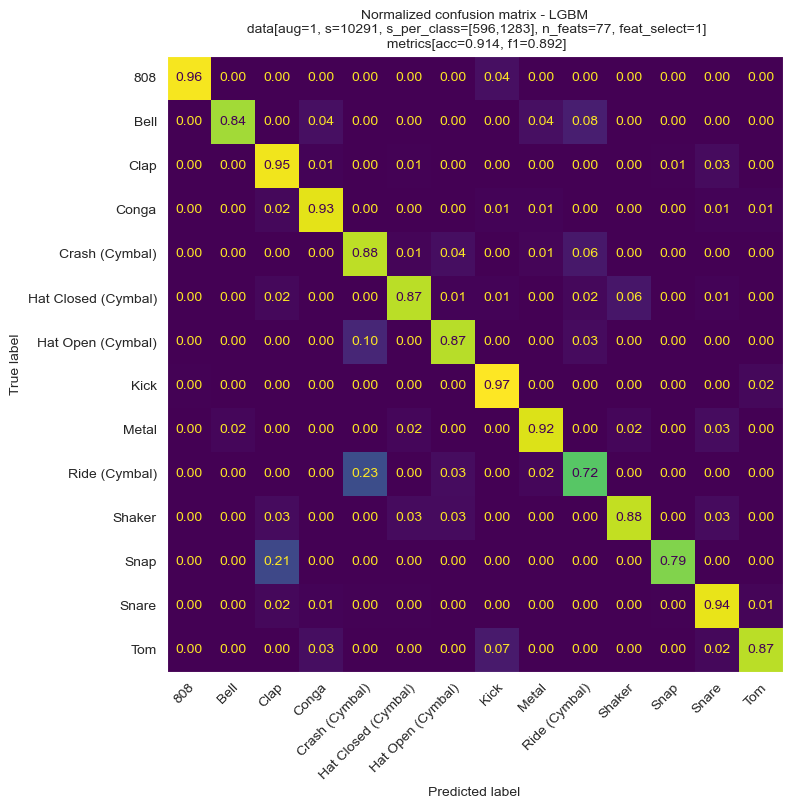

In [125]:
plot_confusion_matrix(y_test, y_pred_lgbm_no_augmented, display_labels=best_lgbm_no_augmented.classes_, normalize=False,
                      title=f"LGBM", save=True, train_params_str=TRAIN_PARAMS_STR)

plot_confusion_matrix(y_test, y_pred_lgbm_augmented, display_labels=best_lgbm_augmented.classes_, normalize=False,
                      title=f"LGBM", save=True, train_params_str=TRAIN_AUGMENTED_PARAMS_STR)

#### Report comparison (with/without augmented trainset)

In [126]:
reports_comparison_lgbm_df = compare_classification_reports(report_lgbm_no_augmented, report_lgbm_augmented, "LGBM")
reports_comparison_lgbm_df

,precision,recall,f1-score
808,nan,-0.009000,-0.005000
Bell,0.122000,0.040000,0.078000
Clap,0.033000,-0.010000,0.011000
Conga,-0.038000,0.011000,-0.014000
Crash (Cymbal),-0.053000,nan,-0.029000
Hat Closed (Cymbal),0.036000,-0.019000,0.007000
Hat Open (Cymbal),0.061000,-0.014000,0.024000
Kick,-0.004000,0.004000,nan
Metal,0.015000,nan,0.007000
Ride (Cymbal),-0.049000,-0.017000,-0.030000


### Variables Importance

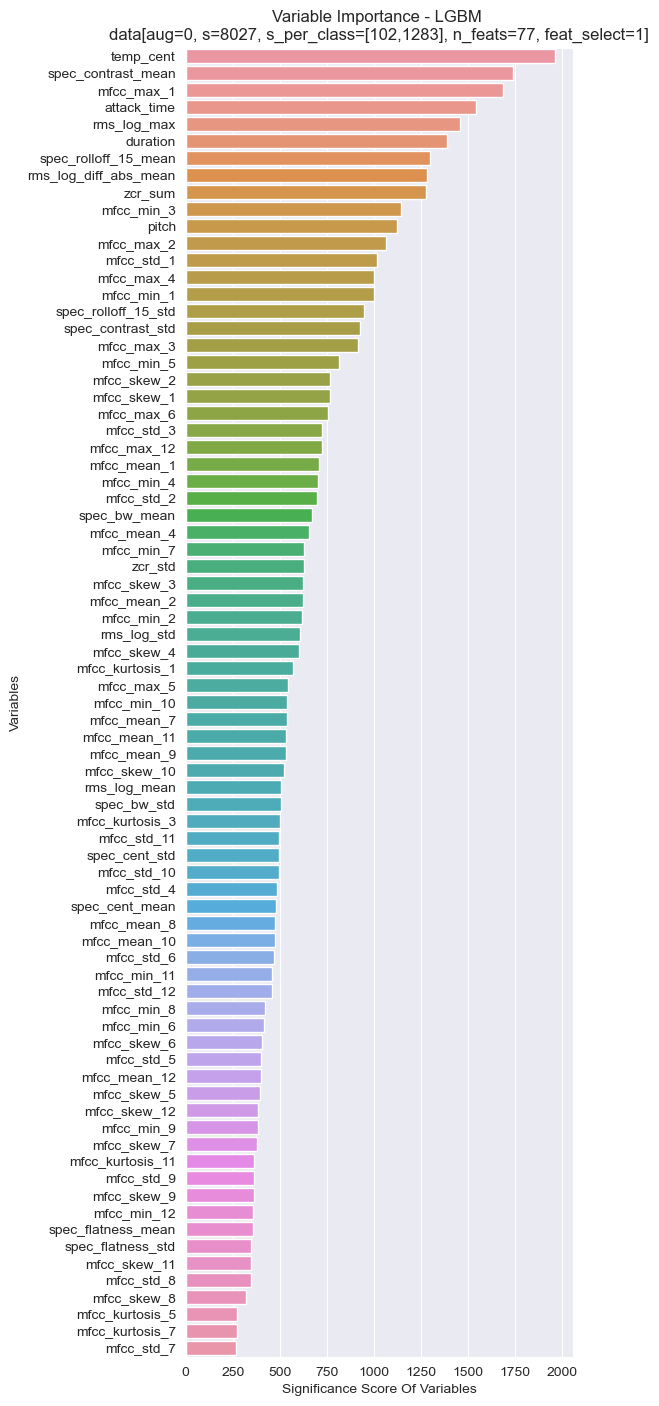

#################### head ####################
temp_cent                1961
spec_contrast_mean       1741
mfcc_max_1               1685
attack_time              1542
rms_log_max              1456
duration                 1389
spec_rolloff_15_mean     1299
rms_log_diff_abs_mean    1280
zcr_sum                  1276
mfcc_min_3               1143
dtype: int32
#################### tail ####################
mfcc_skew_9           361
mfcc_min_12           358
spec_flatness_mean    357
spec_flatness_std     349
mfcc_skew_11          349
mfcc_std_8            345
mfcc_skew_8           323
mfcc_kurtosis_5       275
mfcc_kurtosis_7       273
mfcc_std_7            267
dtype: int32


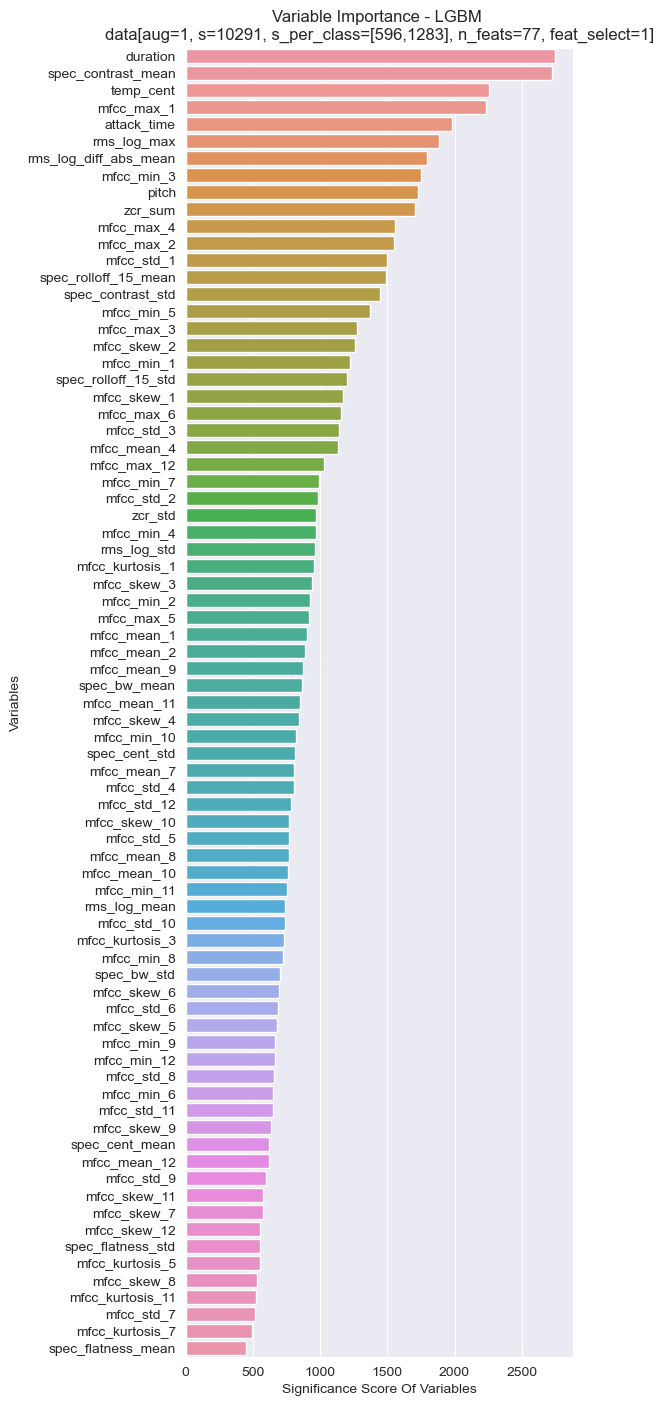

#################### head ####################
duration                 2745
spec_contrast_mean       2726
temp_cent                2260
mfcc_max_1               2237
attack_time              1978
rms_log_max              1887
rms_log_diff_abs_mean    1796
mfcc_min_3               1752
pitch                    1728
zcr_sum                  1704
dtype: int32
#################### tail ####################
mfcc_skew_11          575
mfcc_skew_7           572
mfcc_skew_12          556
spec_flatness_std     553
mfcc_kurtosis_5       551
mfcc_skew_8           530
mfcc_kurtosis_11      521
mfcc_std_7            517
mfcc_kurtosis_7       491
spec_flatness_mean    449
dtype: int32


In [127]:
for model, X_train, train_params in [(best_lgbm_no_augmented, X_train_no_augmented, TRAIN_PARAMS_STR),
                                     (best_lgbm_augmented, X_train_augmented, TRAIN_AUGMENTED_PARAMS_STR)]:
    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    # barplot of feature importances (horizontal barchart)
    fig = plt.figure(figsize=(5, 17))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Significance Score Of Variables')
    plt.ylabel('Variables')
    title = f"Variable Importance - LGBM \ndata[{train_params}]"
    plt.title(title)
    plt.show()
    # prinr head and tail of feature importances
    print("#" * 20, "head", "#" * 20)
    print(feature_imp.head(10))
    print("#" * 20, "tail", "#" * 20)
    print(feature_imp.tail(10))

    # save figure
    now_str = datetime.now().strftime("%Y%m%d")
    title = title.replace("\n", " ")
    fig.savefig(f"{PROJECT_PATH}/plots/{now_str} {title}.png", bbox_inches='tight')

### 💾 Save model

In [128]:
save_ml_model(model=best_lgbm_no_augmented, model_name=f"LGBM data[{TRAIN_PARAMS_STR}]", scaler=scaler,
              features_columns=features_columns)
save_ml_model(model=best_lgbm_augmented, model_name=f"LGBM data[{TRAIN_AUGMENTED_PARAMS_STR}]", scaler=scaler,
              features_columns=features_columns)

> saved successfully 'models/LGBM data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1] 20230514_08.pkl'
> saved successfully 'models/LGBM data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1] 20230514_08.pkl'


## Compare metrics models

 il est important de garder à l'esprit que les performances sur le jeu de données de test ne sont pas toujours représentatives de la performance réelle du modèle sur des données inconnues. Il est donc recommandé d'utiliser des techniques telles que la validation croisée pour évaluer les performances des modèles de manière plus fiable.

### Load models results

In [129]:
df_models_metrics = pd.DataFrame(models_metrics_results)
df_models_metrics.dropna(subset=['acc_test', 'model_name'],
                         inplace=True)  # drop nan values in test_accuracy column and model_name column
df_models_metrics.drop_duplicates(subset=['model_name'], keep='last', inplace=True)
df_models_metrics.sort_values(by="acc_test", inplace=True, ascending=False)  # sort by test accuracy
df_models_metrics.set_index("model_name", inplace=True)
df_models_metrics

,model_trained,acc_test,f1_test,acc_cv_scores_mean,acc_cv_scores_std,f1_cv_scores_mean,f1_cv_scores_std
model_name,,,,,,,
"LGBM data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]","LGBMClassifier(max_depth=20, max_features='aut...",0.91,0.89,0.89,0.03,0.88,0.04
"RandomForest data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]","(DecisionTreeClassifier(max_features='sqrt', r...",0.90,0.87,0.85,0.03,0.84,0.04
"SCV data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1]","SVC(C=10, gamma=1)",0.89,0.85,0.88,0.04,0.82,0.05
"RandomForest data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1]","(DecisionTreeClassifier(max_depth=30, max_feat...",0.89,0.83,0.87,0.02,0.81,0.03
"SCV data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]","SVC(C=100, gamma=0.1)",0.89,0.84,0.87,0.04,0.85,0.05


### display models results

In [130]:
#df_models_metrics["data_info"] = df_models_metrics.index.str.split("data\[").str[1].str.split("\]").str[0]
# keep ***aug=0 or ***aug=1
#df_models_metrics.index = df_models_metrics.index.str.split(",").str[0]
# drop model trained column
#df_models_metrics.drop(columns=["model_trained"], inplace=True)

tmp = df_models_metrics.style.background_gradient(axis=None, vmin=0.6, vmax=1.0)
dfi.export(tmp,
           f'{PROJECT_PATH}/plots/{now_str} Compare metrics models - df_models_metrics - data[{TRAIN_PARAMS_STR}]+data[{TRAIN_AUGMENTED_PARAMS_STR}].png')
tmp

,acc_test,f1_test,acc_cv_scores_mean,acc_cv_scores_std,f1_cv_scores_mean,f1_cv_scores_std
model_name,,,,,,
"LGBM data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]",0.914123,0.892142,0.888935,0.031941,0.878663,0.036789
"RandomForest data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]",0.897090,0.872095,0.854438,0.034883,0.844329,0.039459
"SCV data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1]",0.891412,0.851109,0.878296,0.035249,0.824433,0.052152
"RandomForest data[aug=0, s=8027, s_per_class=[102,1283], n_feats=77, feat_select=1]",0.887864,0.827945,0.871316,0.022180,0.812271,0.030123
"SCV data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]",0.887154,0.842295,0.865132,0.040064,0.853614,0.046953


In [131]:
df_models_metrics.columns

Index(['acc_test', 'f1_test', 'acc_cv_scores_mean', 'acc_cv_scores_std',
       'f1_cv_scores_mean', 'f1_cv_scores_std'],
      dtype='object')

### Plot models results

#### Test Score

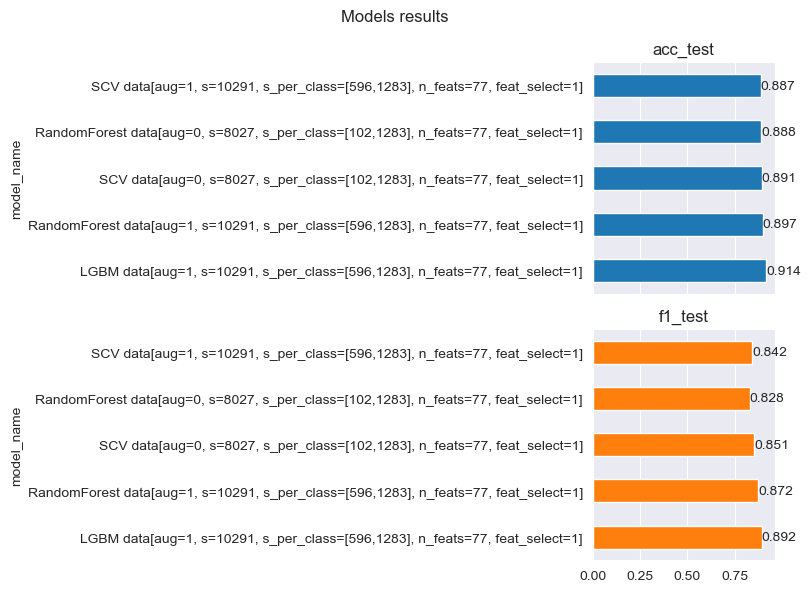

In [132]:
axs = df_models_metrics.plot(kind='barh', y=['acc_test', 'f1_test'], figsize=(8, 3 * 2), title="Models results",
                             subplots=True, legend=False)
from matplotlib.container import BarContainer

for ax in axs:
    max_value = max([rect.get_width() for rect in ax.containers[0]])

    ax.bar_label(ax.containers[0], fmt='{:.3f}')

plt.tight_layout()
plt.show()

fig = axs[0].get_figure()

# save figure

now_str = datetime.now().strftime("%Y%m%d")
fig.savefig(
    f"{PROJECT_PATH}/plots/{now_str} Compare metrics models - bars test - data[{TRAIN_PARAMS_STR}]+data[{TRAIN_AUGMENTED_PARAMS_STR}].png",
    bbox_inches='tight')

In [133]:
# model with best score
df_models_metrics.sort_values(by=["f1_test"], ascending=False).head(1).T

model_name,"LGBM data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]"
acc_test,0.91
f1_test,0.89
acc_cv_scores_mean,0.89
acc_cv_scores_std,0.03
f1_cv_scores_mean,0.88
f1_cv_scores_std,0.04


In [134]:
df_models_metrics.sort_values(by=["acc_test"], ascending=False).head(1).T

model_name,"LGBM data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]"
acc_test,0.91
f1_test,0.89
acc_cv_scores_mean,0.89
acc_cv_scores_std,0.03
f1_cv_scores_mean,0.88
f1_cv_scores_std,0.04


#### Cross Validation Train Score

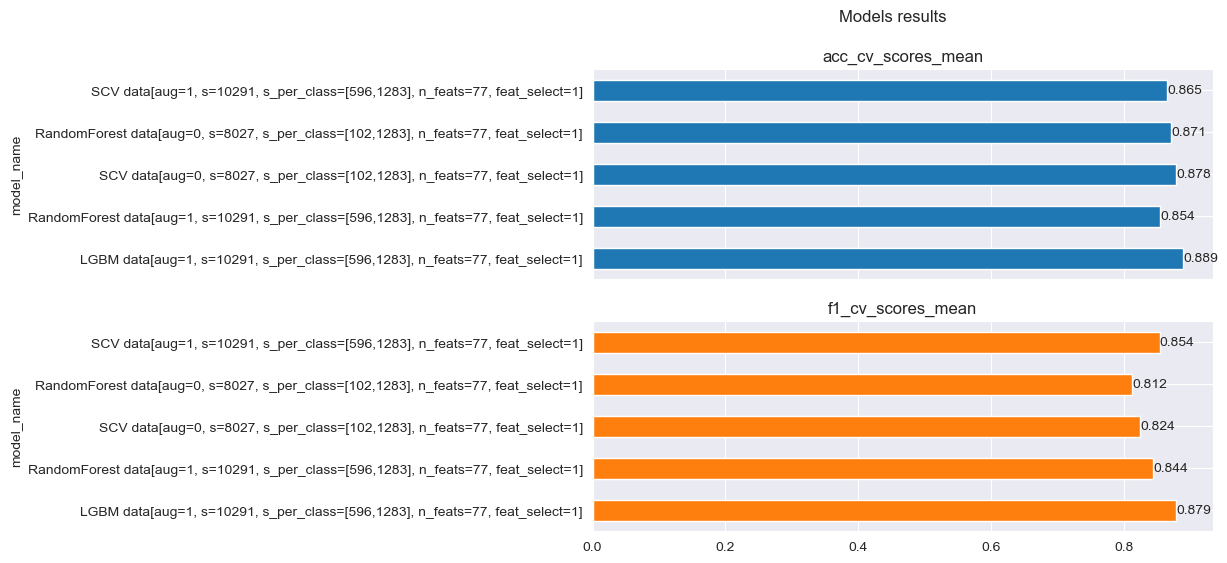

In [135]:
axs = df_models_metrics.plot(kind='barh', y=['acc_cv_scores_mean', 'f1_cv_scores_mean'], figsize=(8, 3 * 2),
                             title="Models results", subplots=True, legend=False)

for ax in axs:
    ax.bar_label(ax.containers[0], fmt='{:.3f}')

plt.show()

# save figure
fig = axs[0].get_figure()
now_str = datetime.now().strftime("%Y%m%d")
fig.savefig(
    f"{PROJECT_PATH}/plots/{now_str} Compare metrics models - bars cv - data[{TRAIN_PARAMS_STR}]+data[{TRAIN_AUGMENTED_PARAMS_STR}].png",
    bbox_inches='tight')

In [136]:
df_models_metrics.sort_values(by=['acc_cv_scores_mean'], ascending=False).head(1).T

model_name,"LGBM data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]"
acc_test,0.91
f1_test,0.89
acc_cv_scores_mean,0.89
acc_cv_scores_std,0.03
f1_cv_scores_mean,0.88
f1_cv_scores_std,0.04


In [137]:
df_models_metrics.sort_values(by=['f1_cv_scores_mean'], ascending=False).head(1).T

model_name,"LGBM data[aug=1, s=10291, s_per_class=[596,1283], n_feats=77, feat_select=1]"
acc_test,0.91
f1_test,0.89
acc_cv_scores_mean,0.89
acc_cv_scores_std,0.03
f1_cv_scores_mean,0.88
f1_cv_scores_std,0.04


### Conclusion after comparison

- Il est également important de prendre en compte d'autres facteurs tels que la complexité du modèle, le temps d'entraînement et de prédiction, et la capacité à généraliser à de nouvelles données. Il peut être judicieux de choisir un modèle plus simple qui a des performances légèrement inférieures si cela permet une meilleure généralisation et une mise en production plus facile.
- Si vous utilisez des modèles de types différents, il peut être intéressant de comparer leurs performances en termes de vitesse d'entraînement et de prédiction, ainsi que de complexité et d'interprétabilité.

LSGM : 3h
## 👑 Who is the best
